<a href="https://colab.research.google.com/github/marcelohpos/PROJETO-ICD/blob/master/icd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalar dependência (só precisa rodar uma vez)
!pip install geopy seaborn

In [2]:
# Importar bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import time
import plotly.express as px
import plotly.graph_objects as go
import numpy as np # Adicionado para melhor manipulação, se necessário, mas não é estritamente obrigatório aqui

##**Análises Gerais:**

In [3]:
# Carregar os dados
url = "https://raw.githubusercontent.com/marcelohpos/PROJETO-ICD/master/datasets/LA_daily_air_quality.csv"
dados_clima = pd.read_csv(url)

In [4]:
dados_clima.columns = ['Data', 'Latitude', 'Longitude', 'PM10', 'PM2_5', 'Monóxido de Carbono (CO2)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']

In [5]:
dados_clima

Data  Latitude  Longitude  PM10  PM2_5  \
0      2022-07-29 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
1      2022-07-30 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
2      2022-07-31 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
3      2022-08-01 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
4      2022-08-02 00:00:00+00:00  -34.6037   -58.3816   NaN    NaN   
...                          ...       ...        ...   ...    ...   
12635  2024-04-16 00:00:00+00:00   10.4806   -66.9036   9.3    6.1   
12636  2024-04-17 00:00:00+00:00   10.4806   -66.9036  28.5   19.6   
12637  2024-04-18 00:00:00+00:00   10.4806   -66.9036  23.1   16.2   
12638  2024-04-19 00:00:00+00:00   10.4806   -66.9036  40.7   29.1   
12639  2024-04-20 00:00:00+00:00   10.4806   -66.9036  15.1   10.7   

       Monóxido de Carbono (CO2)  Dióxido de Nitrogênio (NO2)  \
0                            NaN                          NaN   
1                            NaN                          NaN   
2                            NaN                          NaN   
3                            NaN                          NaN   
4                            NaN                          NaN   
...                          ...                          ...   
12635                      232.0                          7.3   
12636                      510.0                         18.5   
12637                      446.0                         14.2   
12638                      775.0                         26.5   
12639                      491.0                         18.0   

       Dioxido de Enxofre(SO2)  Ozônio(O3)  
0                          NaN         NaN  
1                          NaN         NaN  
2                          NaN         NaN  
3                          NaN         NaN  
4                          NaN         NaN  
...                        ...         ...  
12635                      2.1        41.0  
12636                      3.4        36.0  
12637                      3.2        58.0  
12638                      5.6        49.0  
12639                      3.4        31.0  

[12640 rows x 9 columns]

/tmp/ipython-input-4173522718.py:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




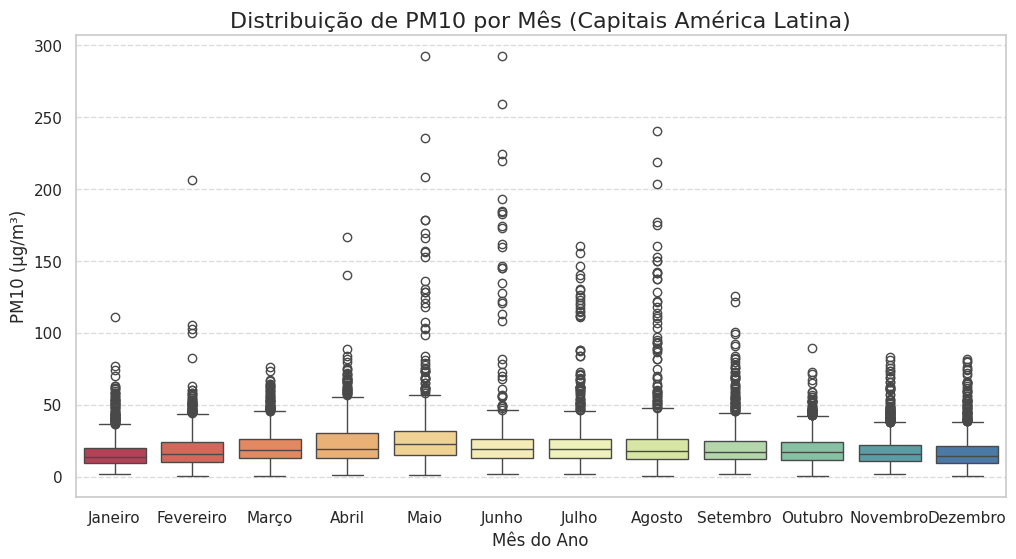

/tmp/ipython-input-4173522718.py:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




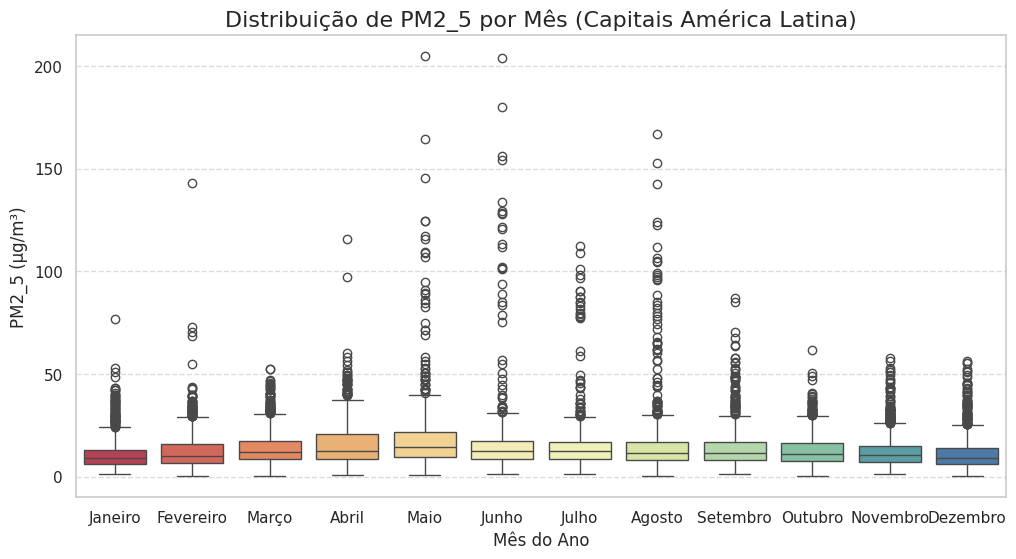

/tmp/ipython-input-4173522718.py:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




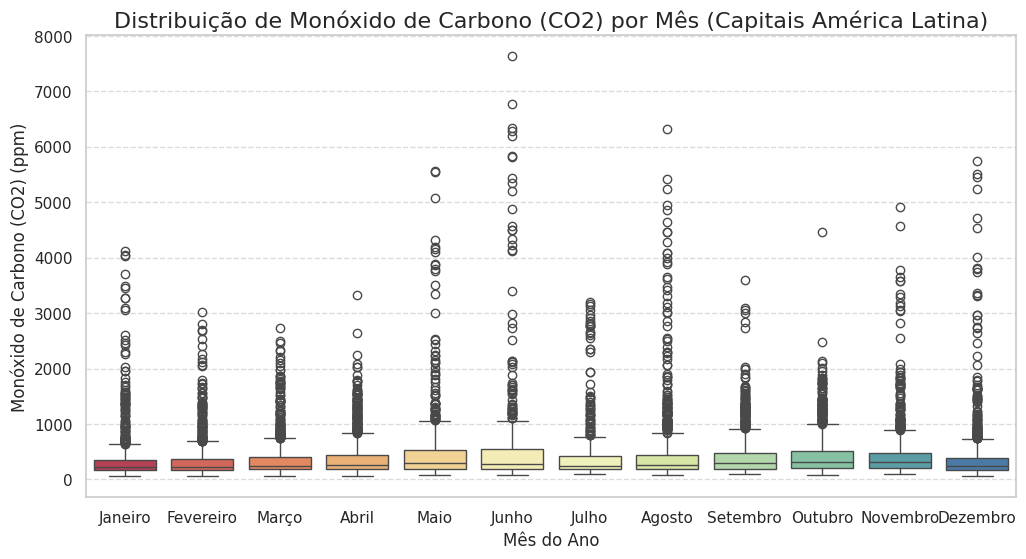

/tmp/ipython-input-4173522718.py:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




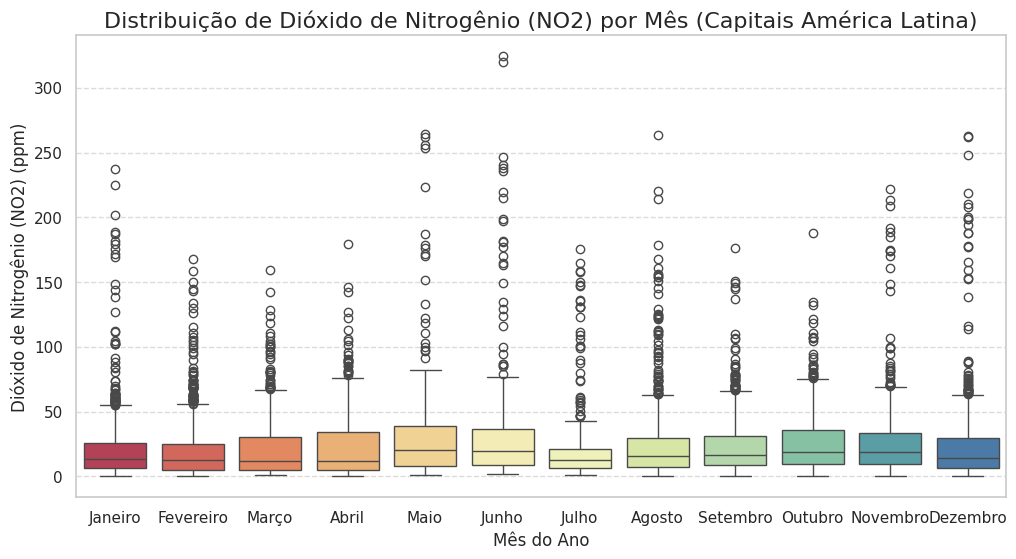

/tmp/ipython-input-4173522718.py:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




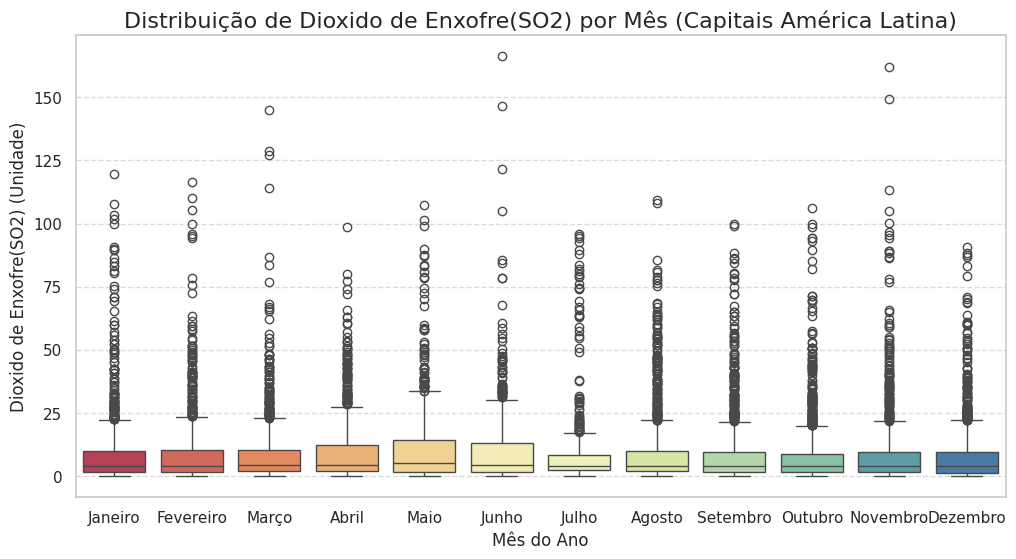

/tmp/ipython-input-4173522718.py:48: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




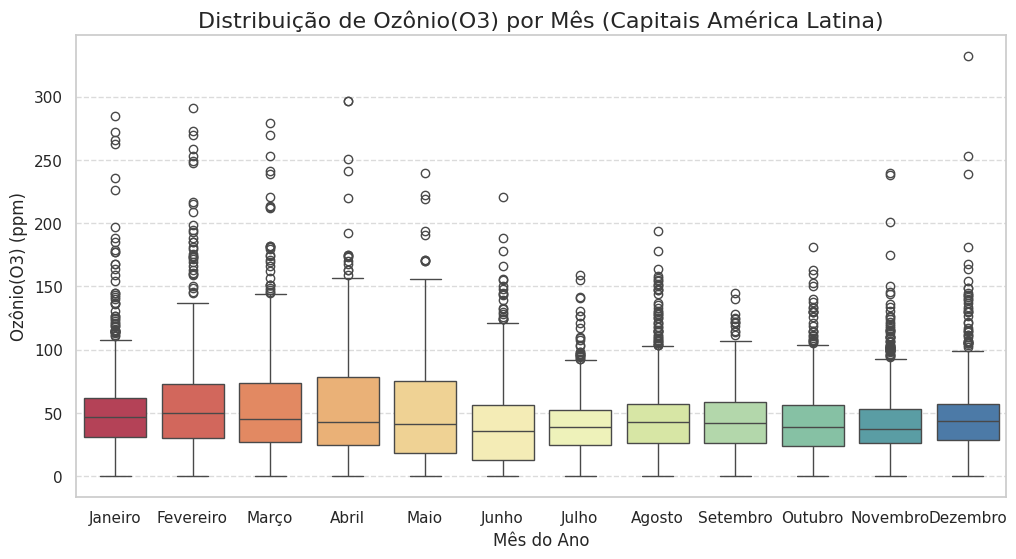

In [14]:
# --- 0. PRÉ-PROCESSAMENTO DE DADOS (Manter a extração de data) ---

# 1. Garantir que a coluna 'Data' seja do tipo datetime
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')
# Não filtramos o PM10 ainda, pois faremos isso dinamicamente no loop
df_sazonal = dados_clima.dropna(subset=['Data']).copy()

# 2. DEFINIÇÃO DOS DICIONÁRIOS DE TRADUÇÃO
traducao_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
# Extração das colunas em Português
df_sazonal['Mês_Nome'] = df_sazonal['Data'].dt.month.map(traducao_meses)
ordem_meses_pt = list(traducao_meses.values())

# 3. IDENTIFICAÇÃO DOS INDICADORES
# Lista de colunas que representam indicadores de poluição na sua base
indicadores_poluicao = ['PM10', 'PM2_5', 'Monóxido de Carbono (CO2)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']

# Mapeamento de unidade e título (para o gráfico ficar mais limpo)
unidades = {
    'PM10': 'μg/m³',
    'PM2_5': 'μg/m³',
    'Ozônio(O3)': 'ppm',
    'Dióxido de Nitrogênio (NO2)': 'ppm',
    'Monóxido de Carbono (CO2)': 'ppm',
    'Dióxido de Enxofre(SO2)':'ppm'
}

# --- 4. FUNÇÃO PARA GERAR O GRÁFICO POR INDICADOR ---

def plot_sazonal_por_indicador(df, indicador, ordem_eixo, unidade):
    # Remove NaN apenas para a coluna do indicador atual
    df_plot = df.dropna(subset=[indicador, 'Mês_Nome'])

    if df_plot.empty:
        print(f"Aviso: Não há dados válidos para o indicador {indicador}.")
        return

    plt.figure(figsize=(12, 6))

    sns.boxplot(
        data=df_plot,
        x='Mês_Nome',
        y=indicador,
        order=ordem_eixo,
        palette='Spectral'
    )

    # Cria o título e rótulo dinamicamente
    titulo = f'Distribuição de {indicador} por Mês (Capitais América Latina)'
    eixo_y = f'{indicador} ({unidade.get(indicador, "Unidade")})'

    plt.title(titulo, fontsize=16)
    plt.xlabel('Mês do Ano', fontsize=12)
    plt.ylabel(eixo_y, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# --- 5. EXECUÇÃO DO LOOP ---

for indicador in indicadores_poluicao:
    # Obtém a unidade do indicador atual ou usa um valor padrão
    unidade_atual = unidades.get(indicador, 'Unidade')

    # Chama a função para gerar o gráfico Box Plot do Mês
    plot_sazonal_por_indicador(df_sazonal, indicador, ordem_meses_pt, unidades)

1- Como a qualidade do ar em Brasília se compara com a das capitais de outros países como Chile, Colômbia ou Argentina?

✅ Indicadores prontos para histogramas: ['PM10', 'PM2_5', 'Monóxido de Carbono (CO2)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']


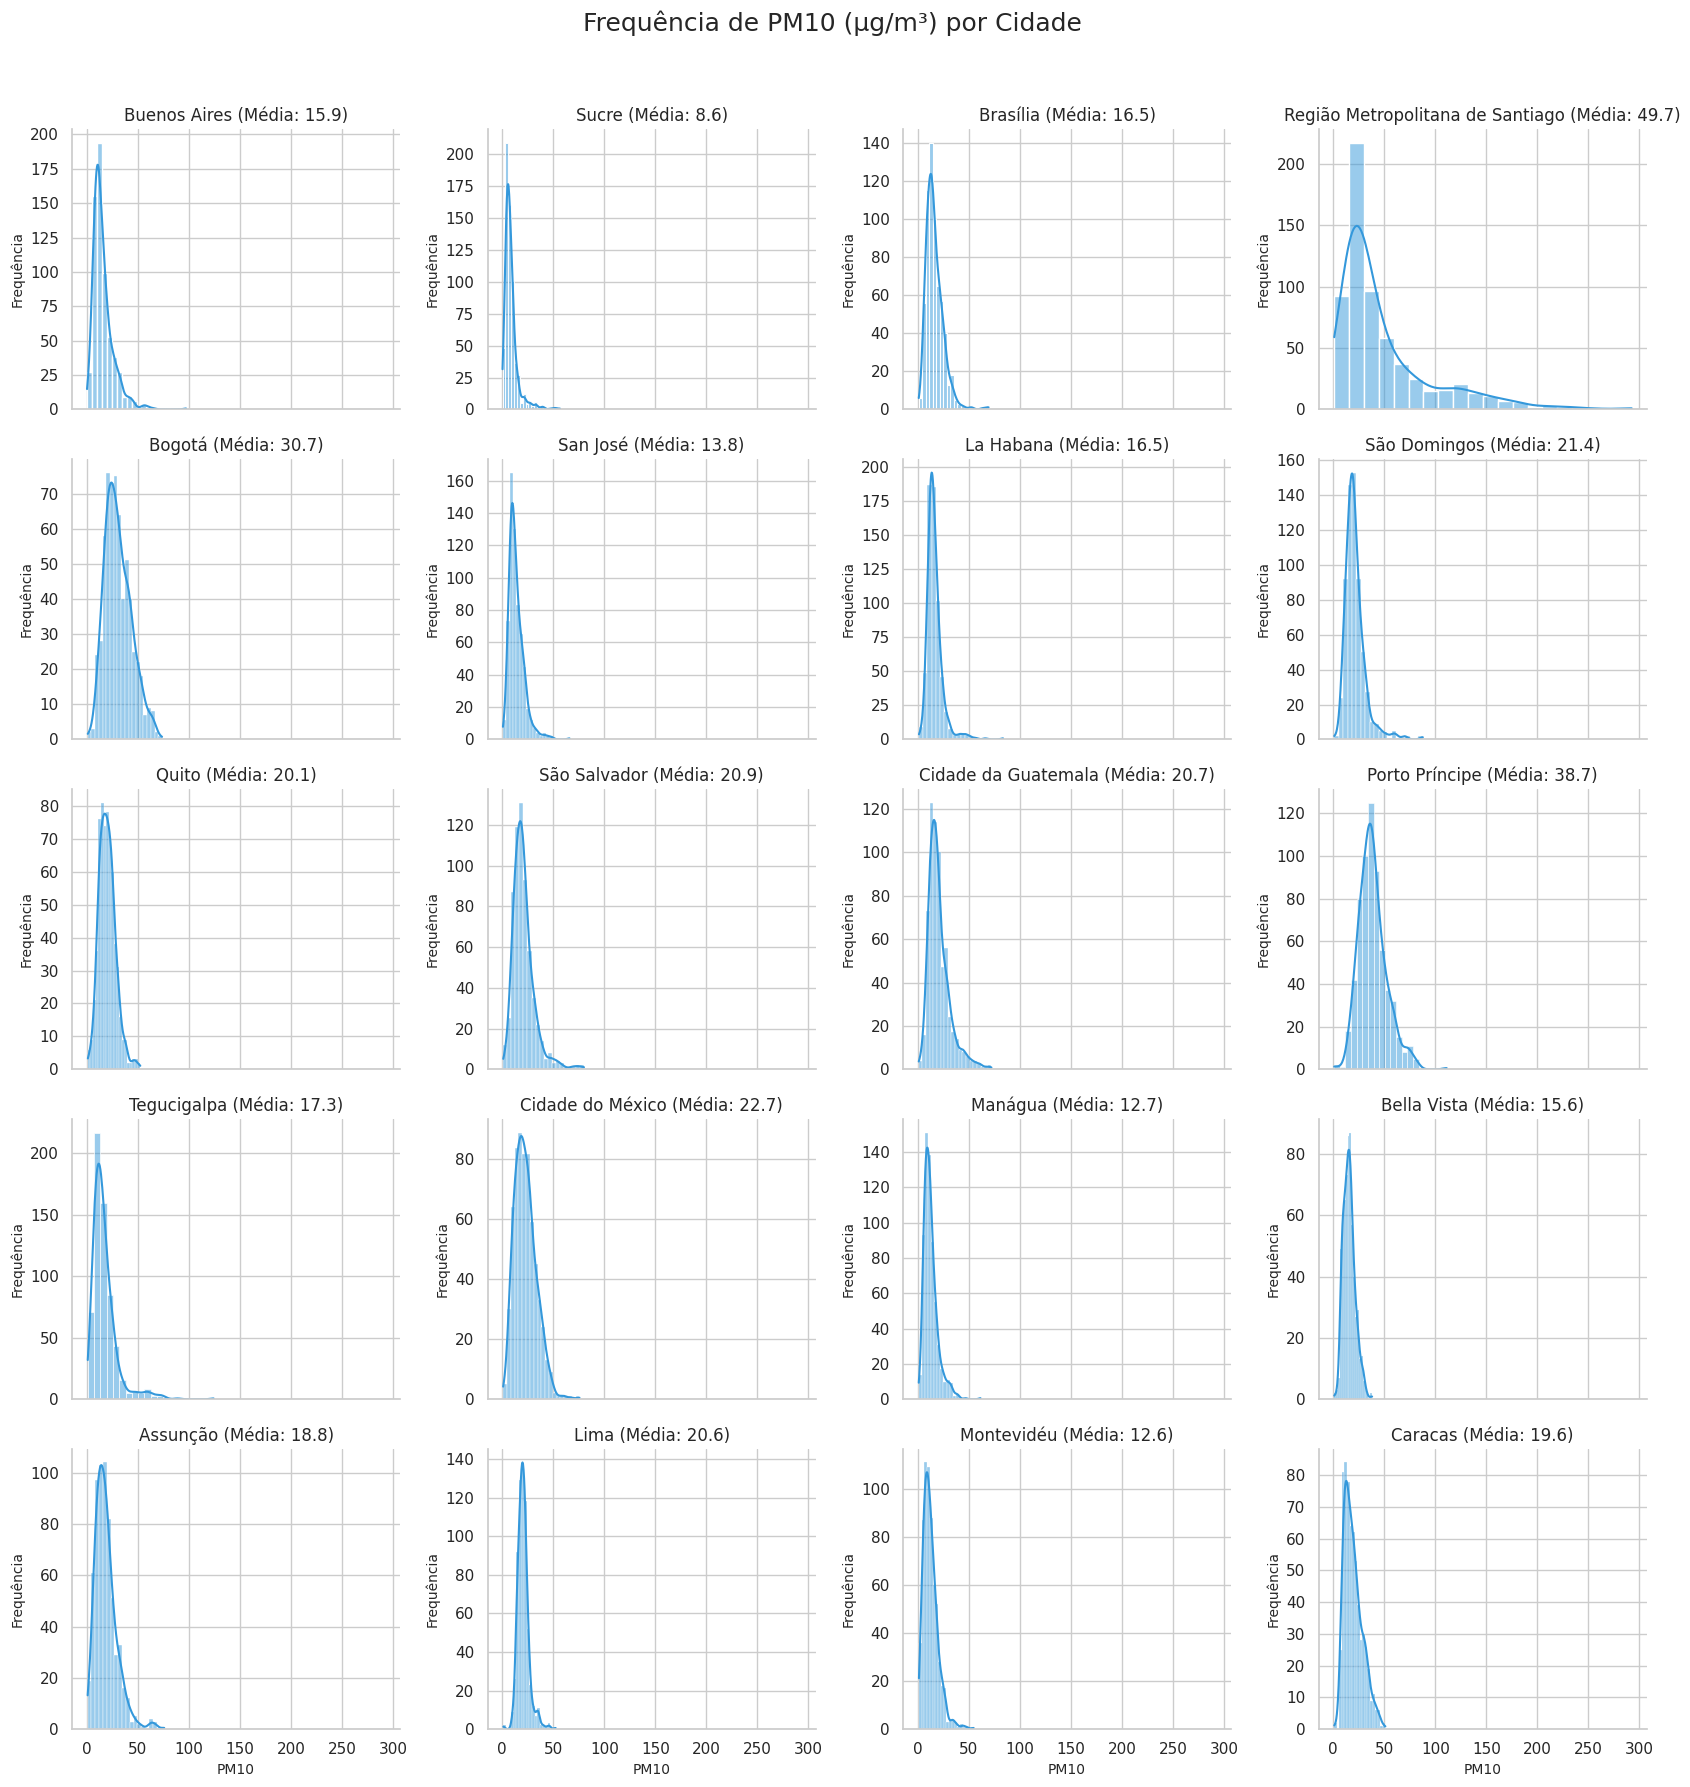

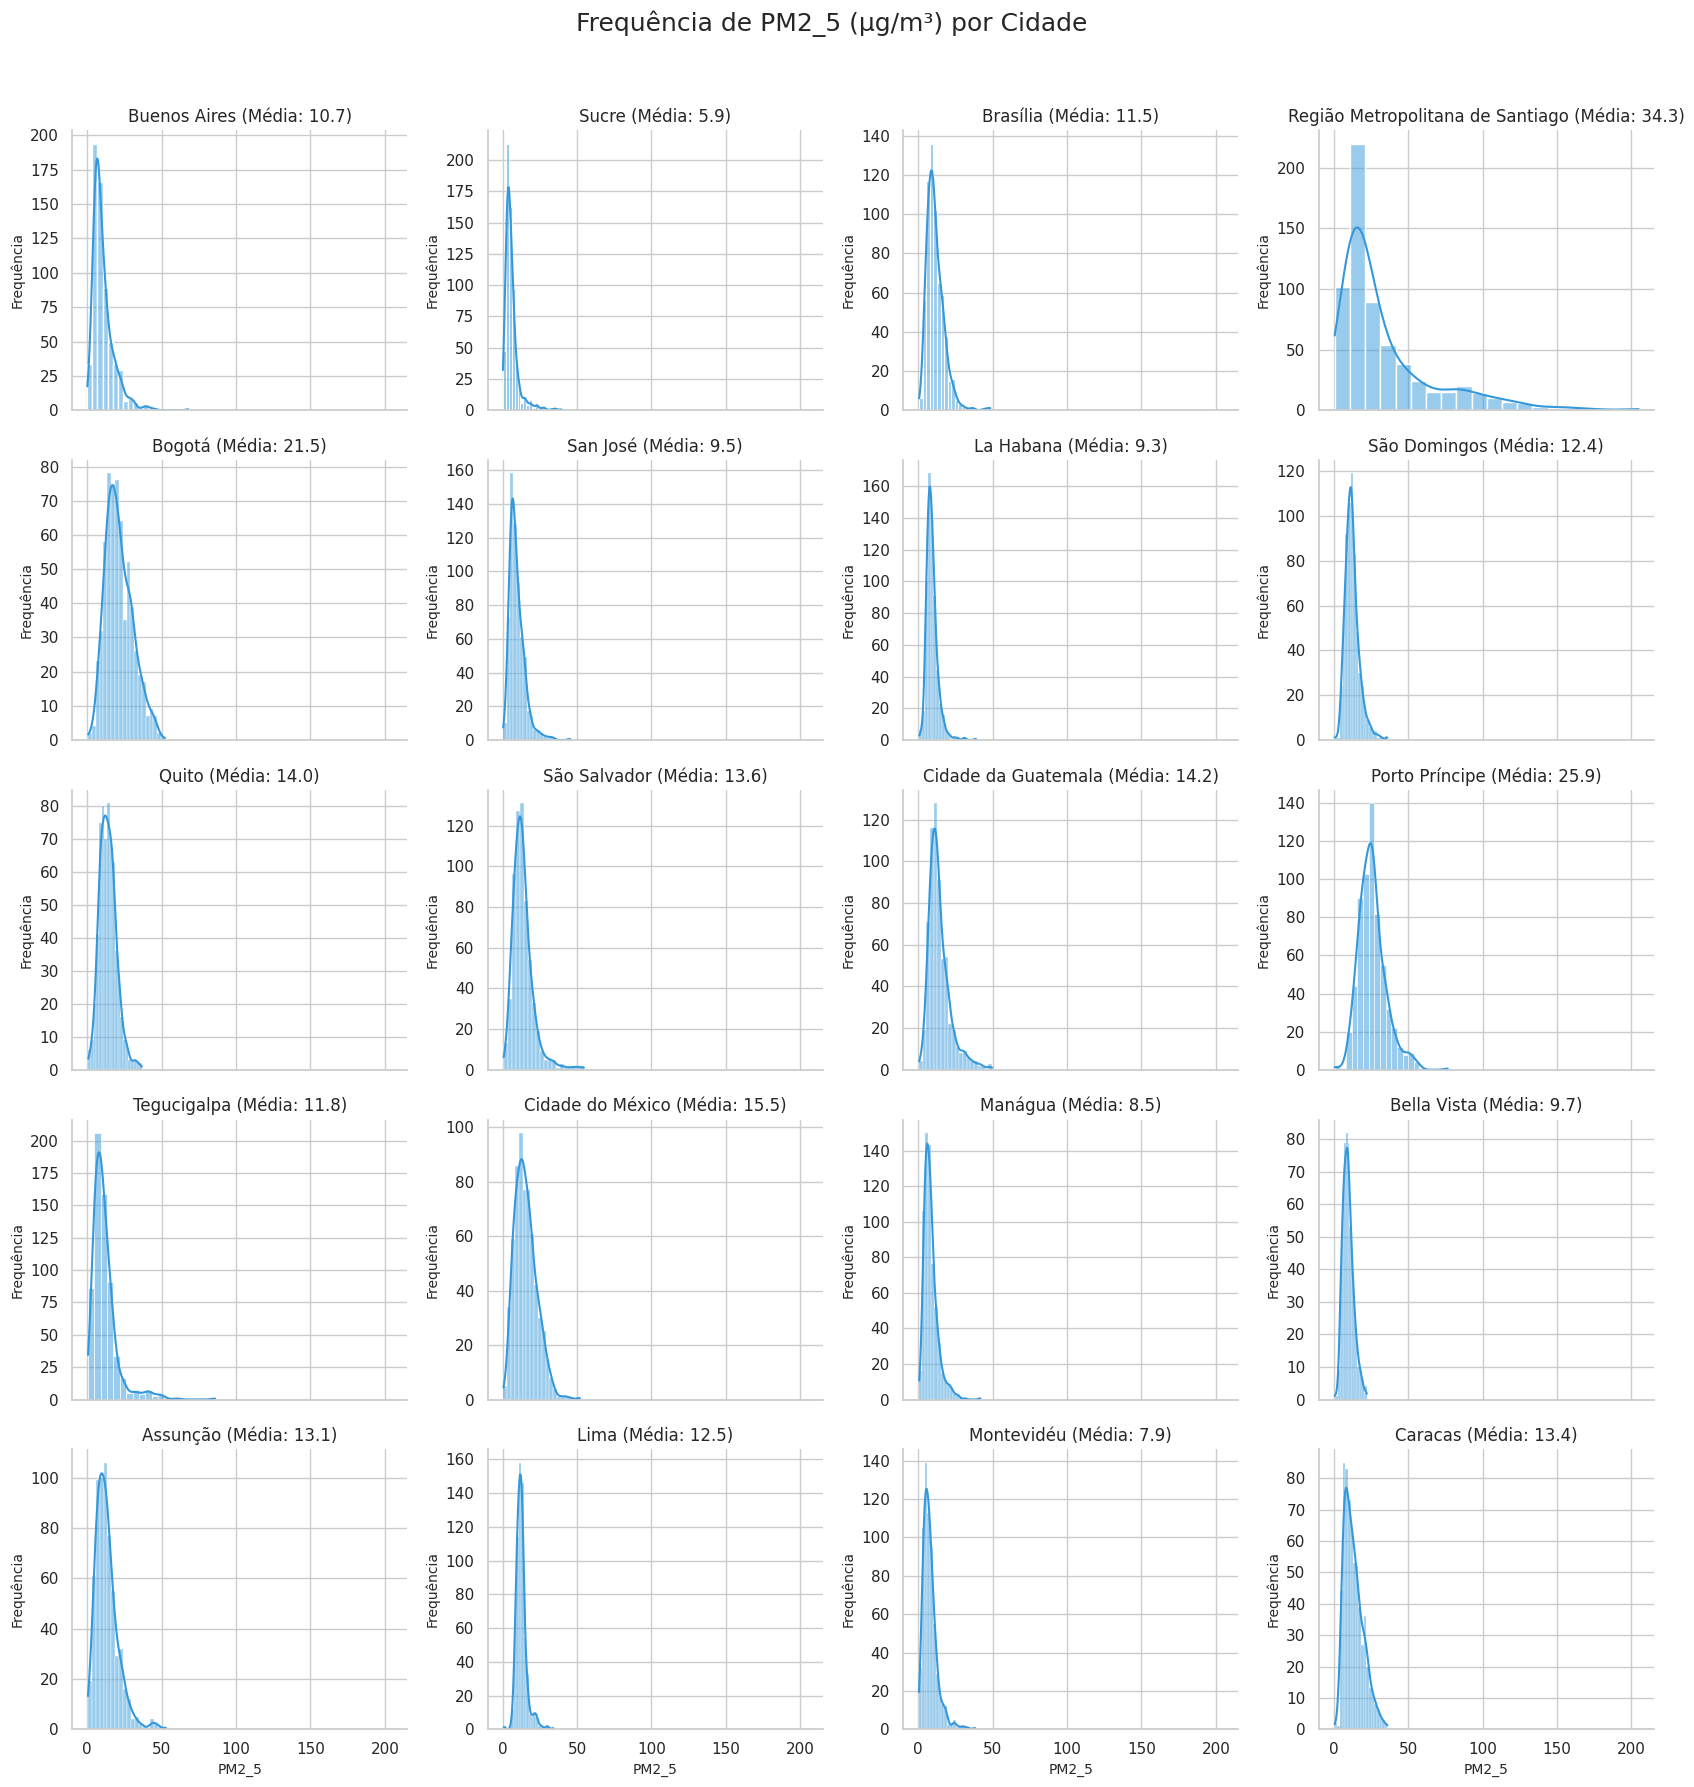

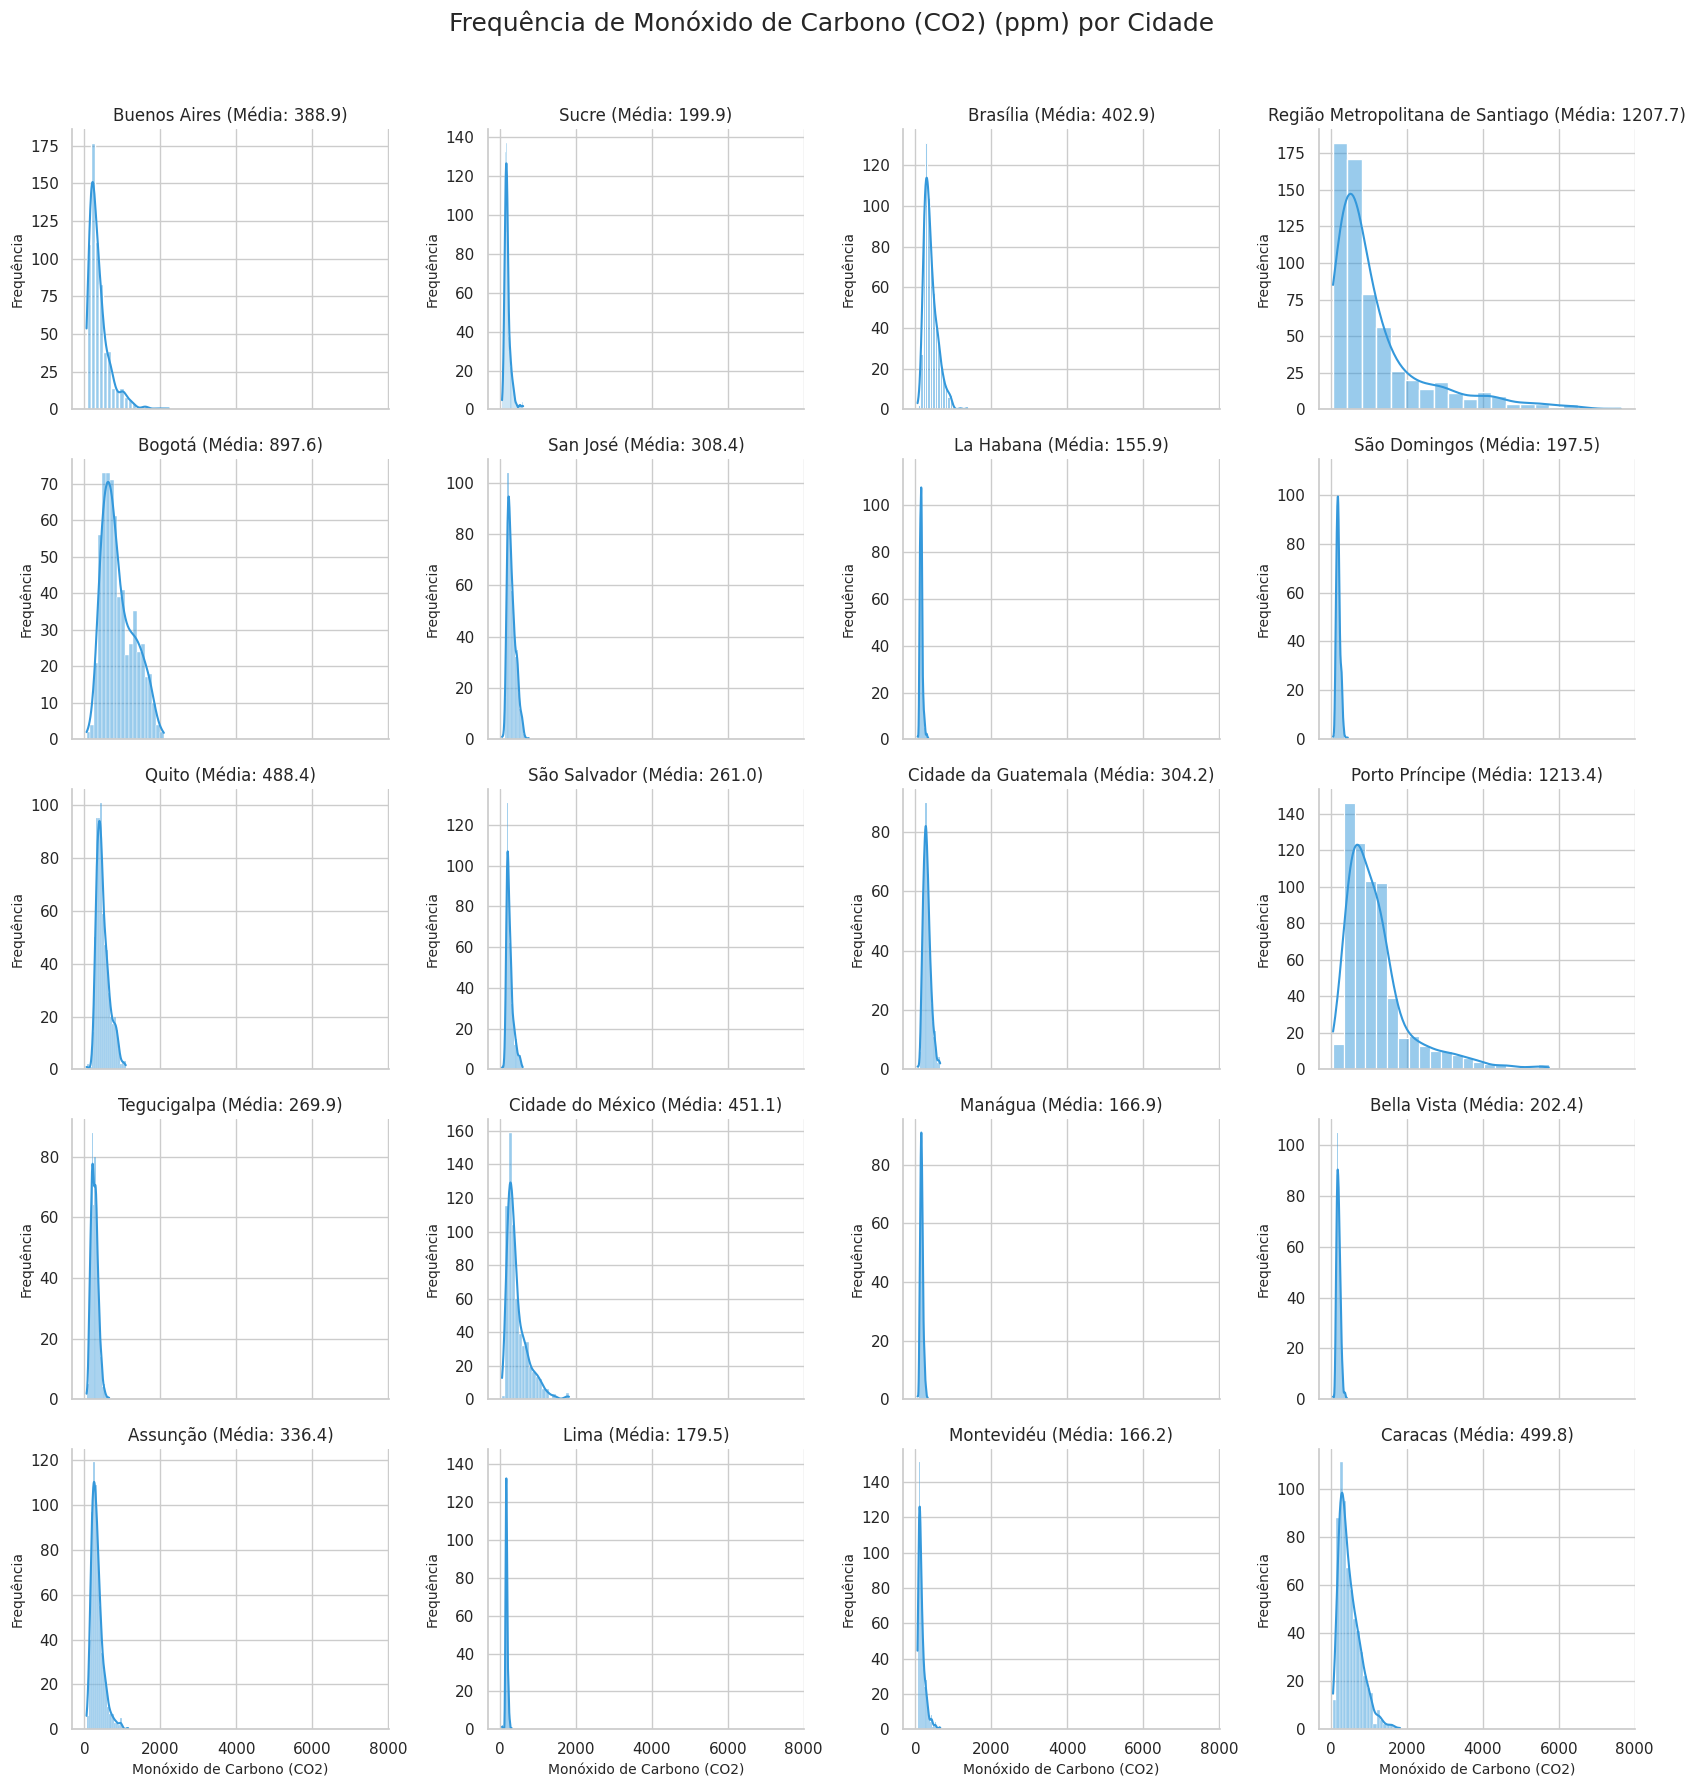

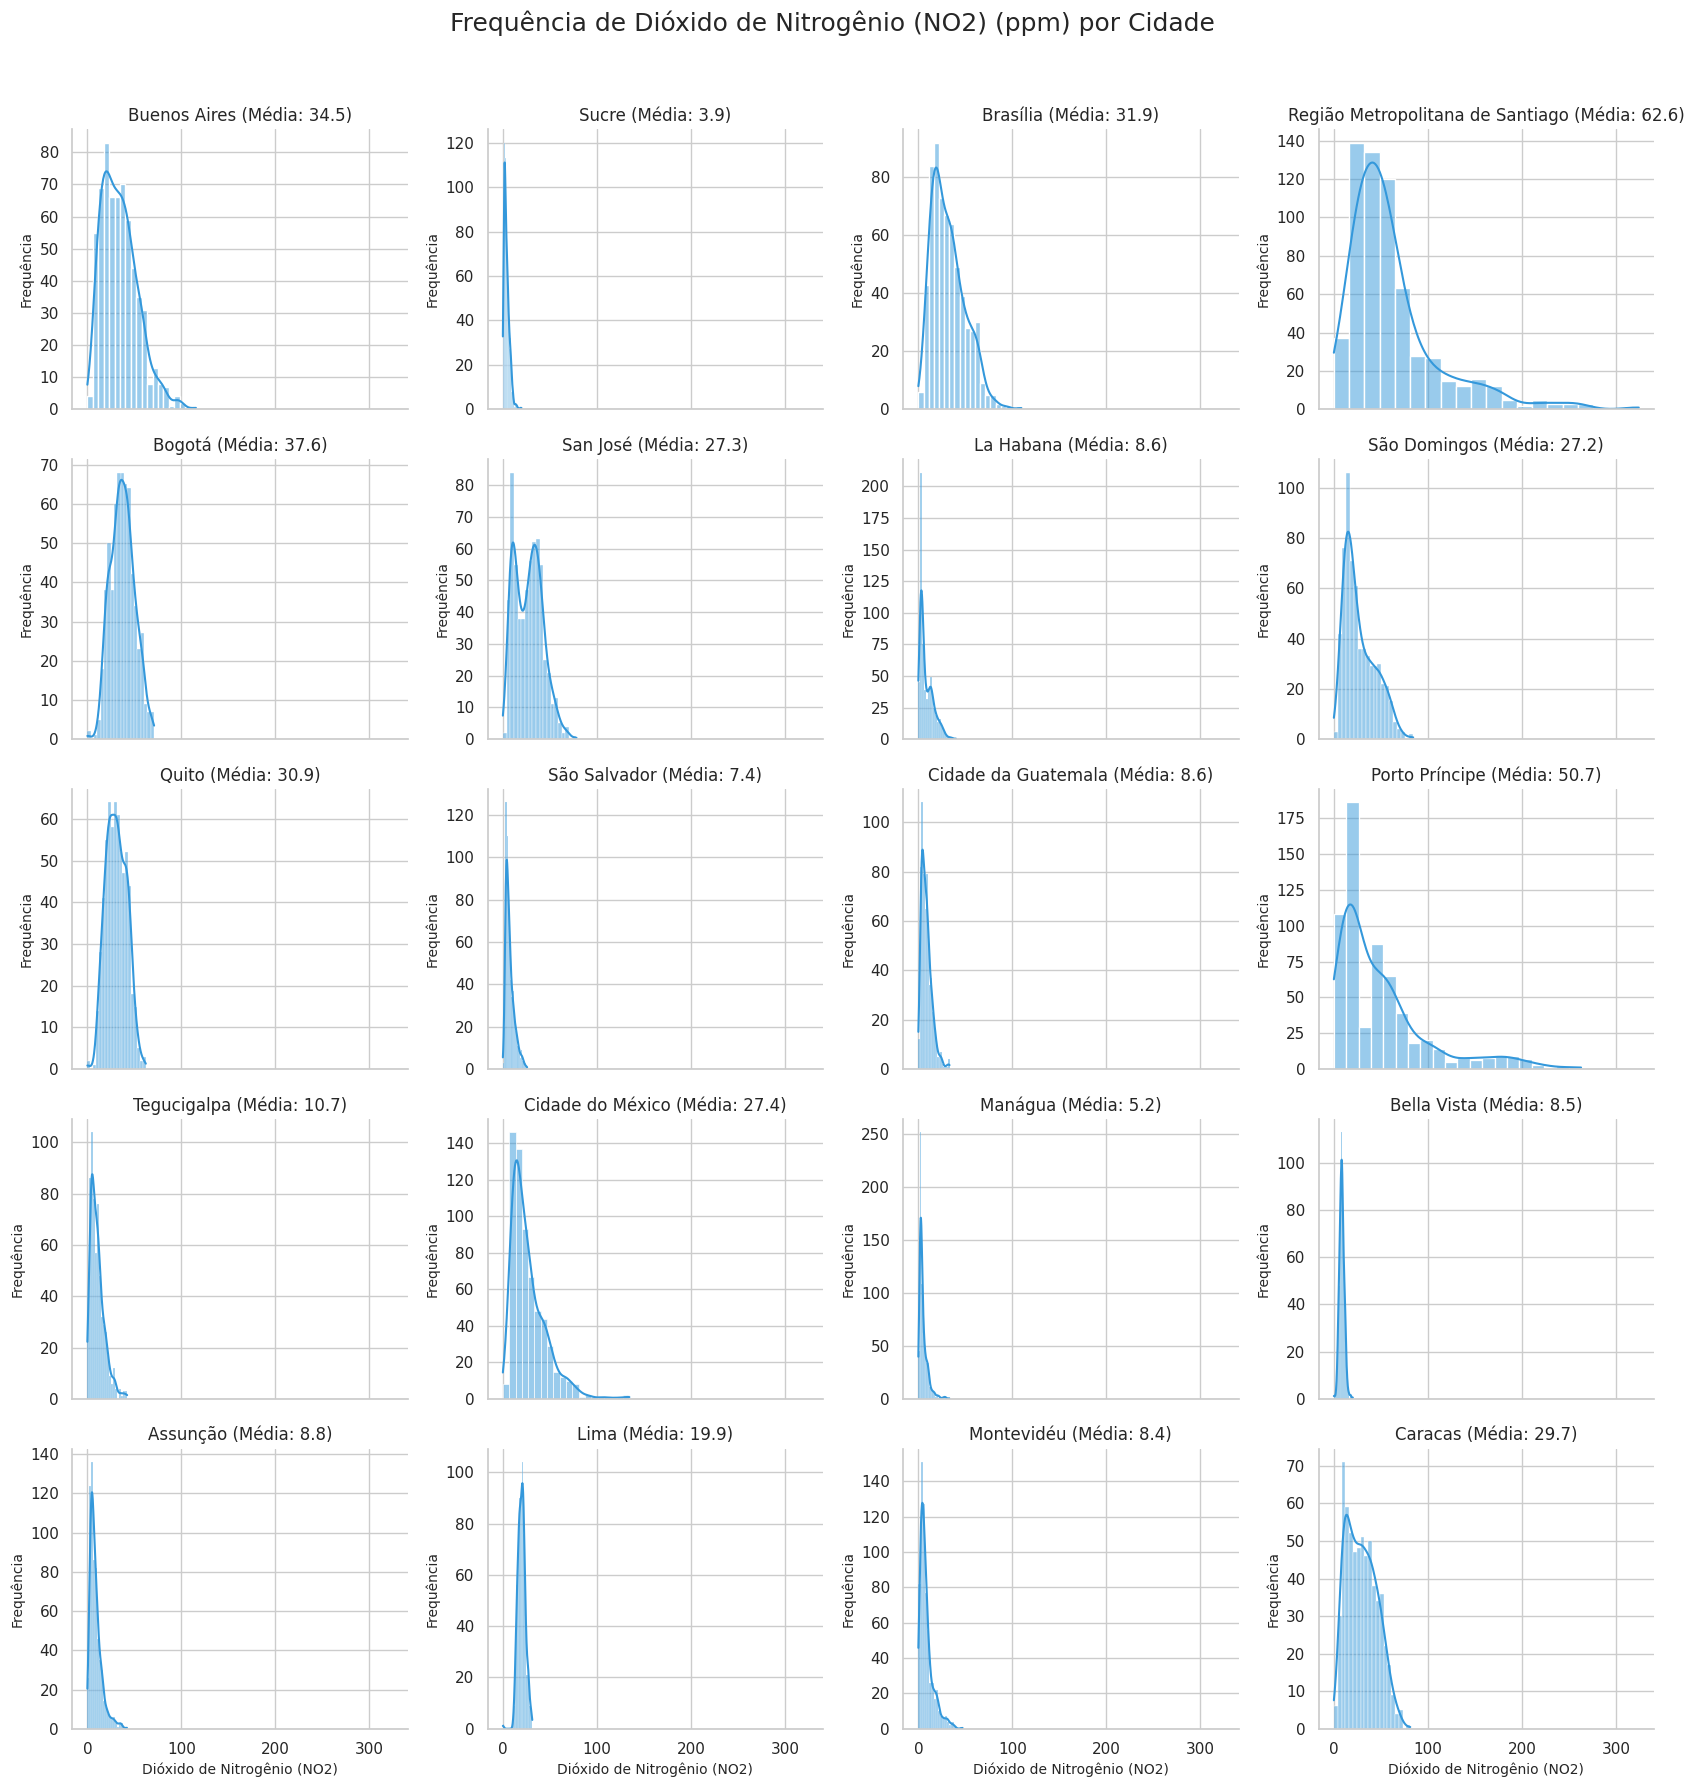

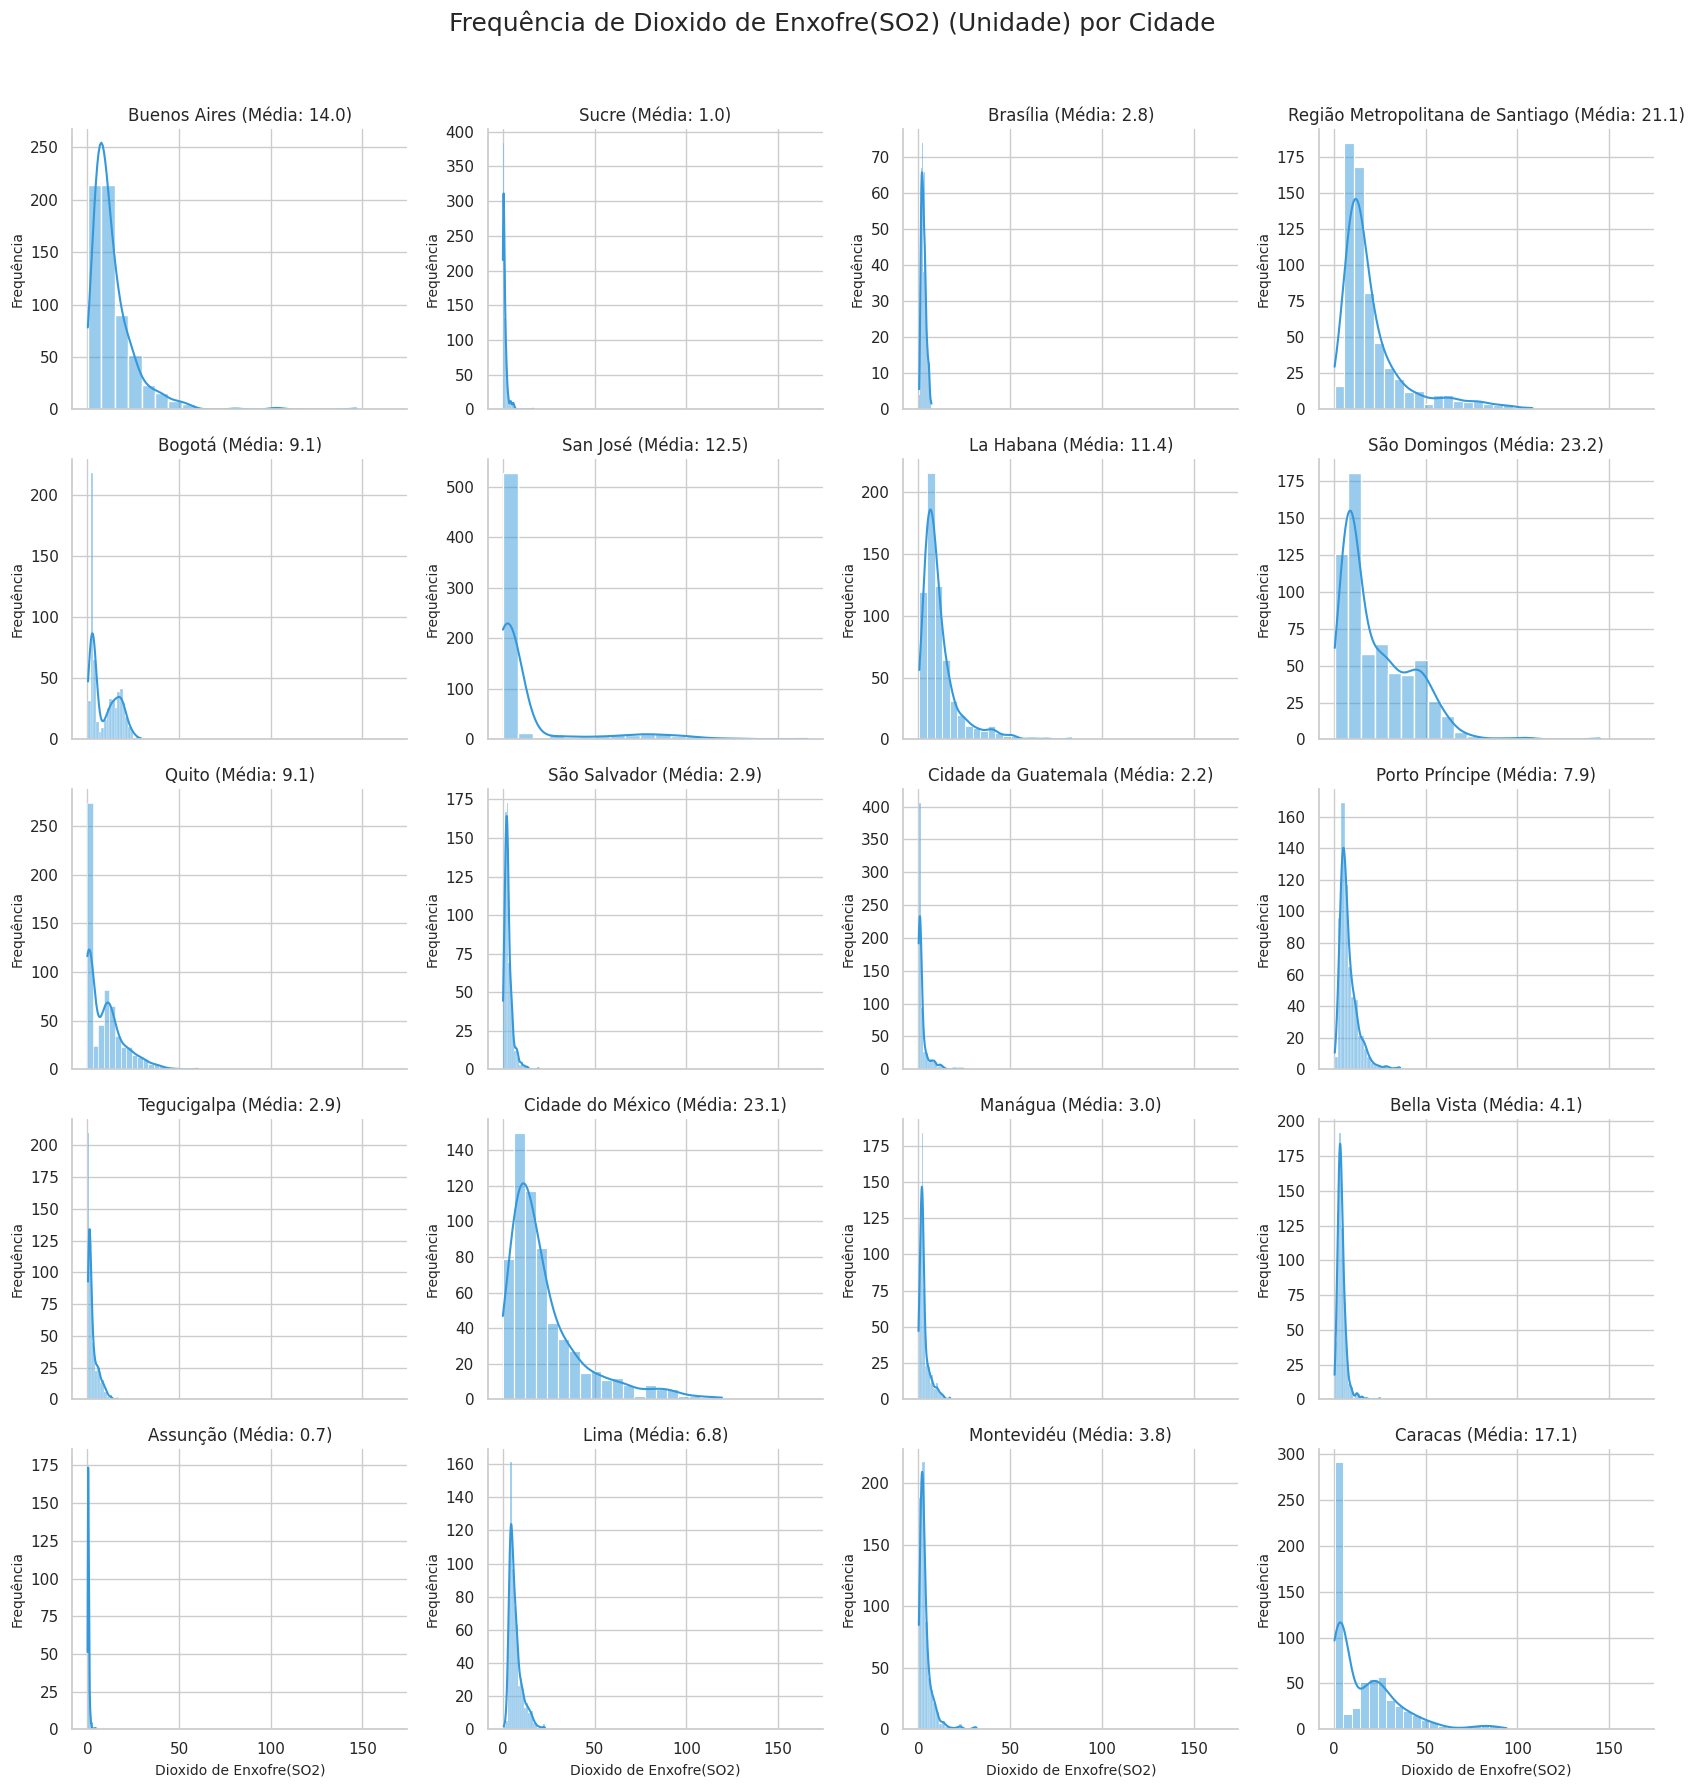

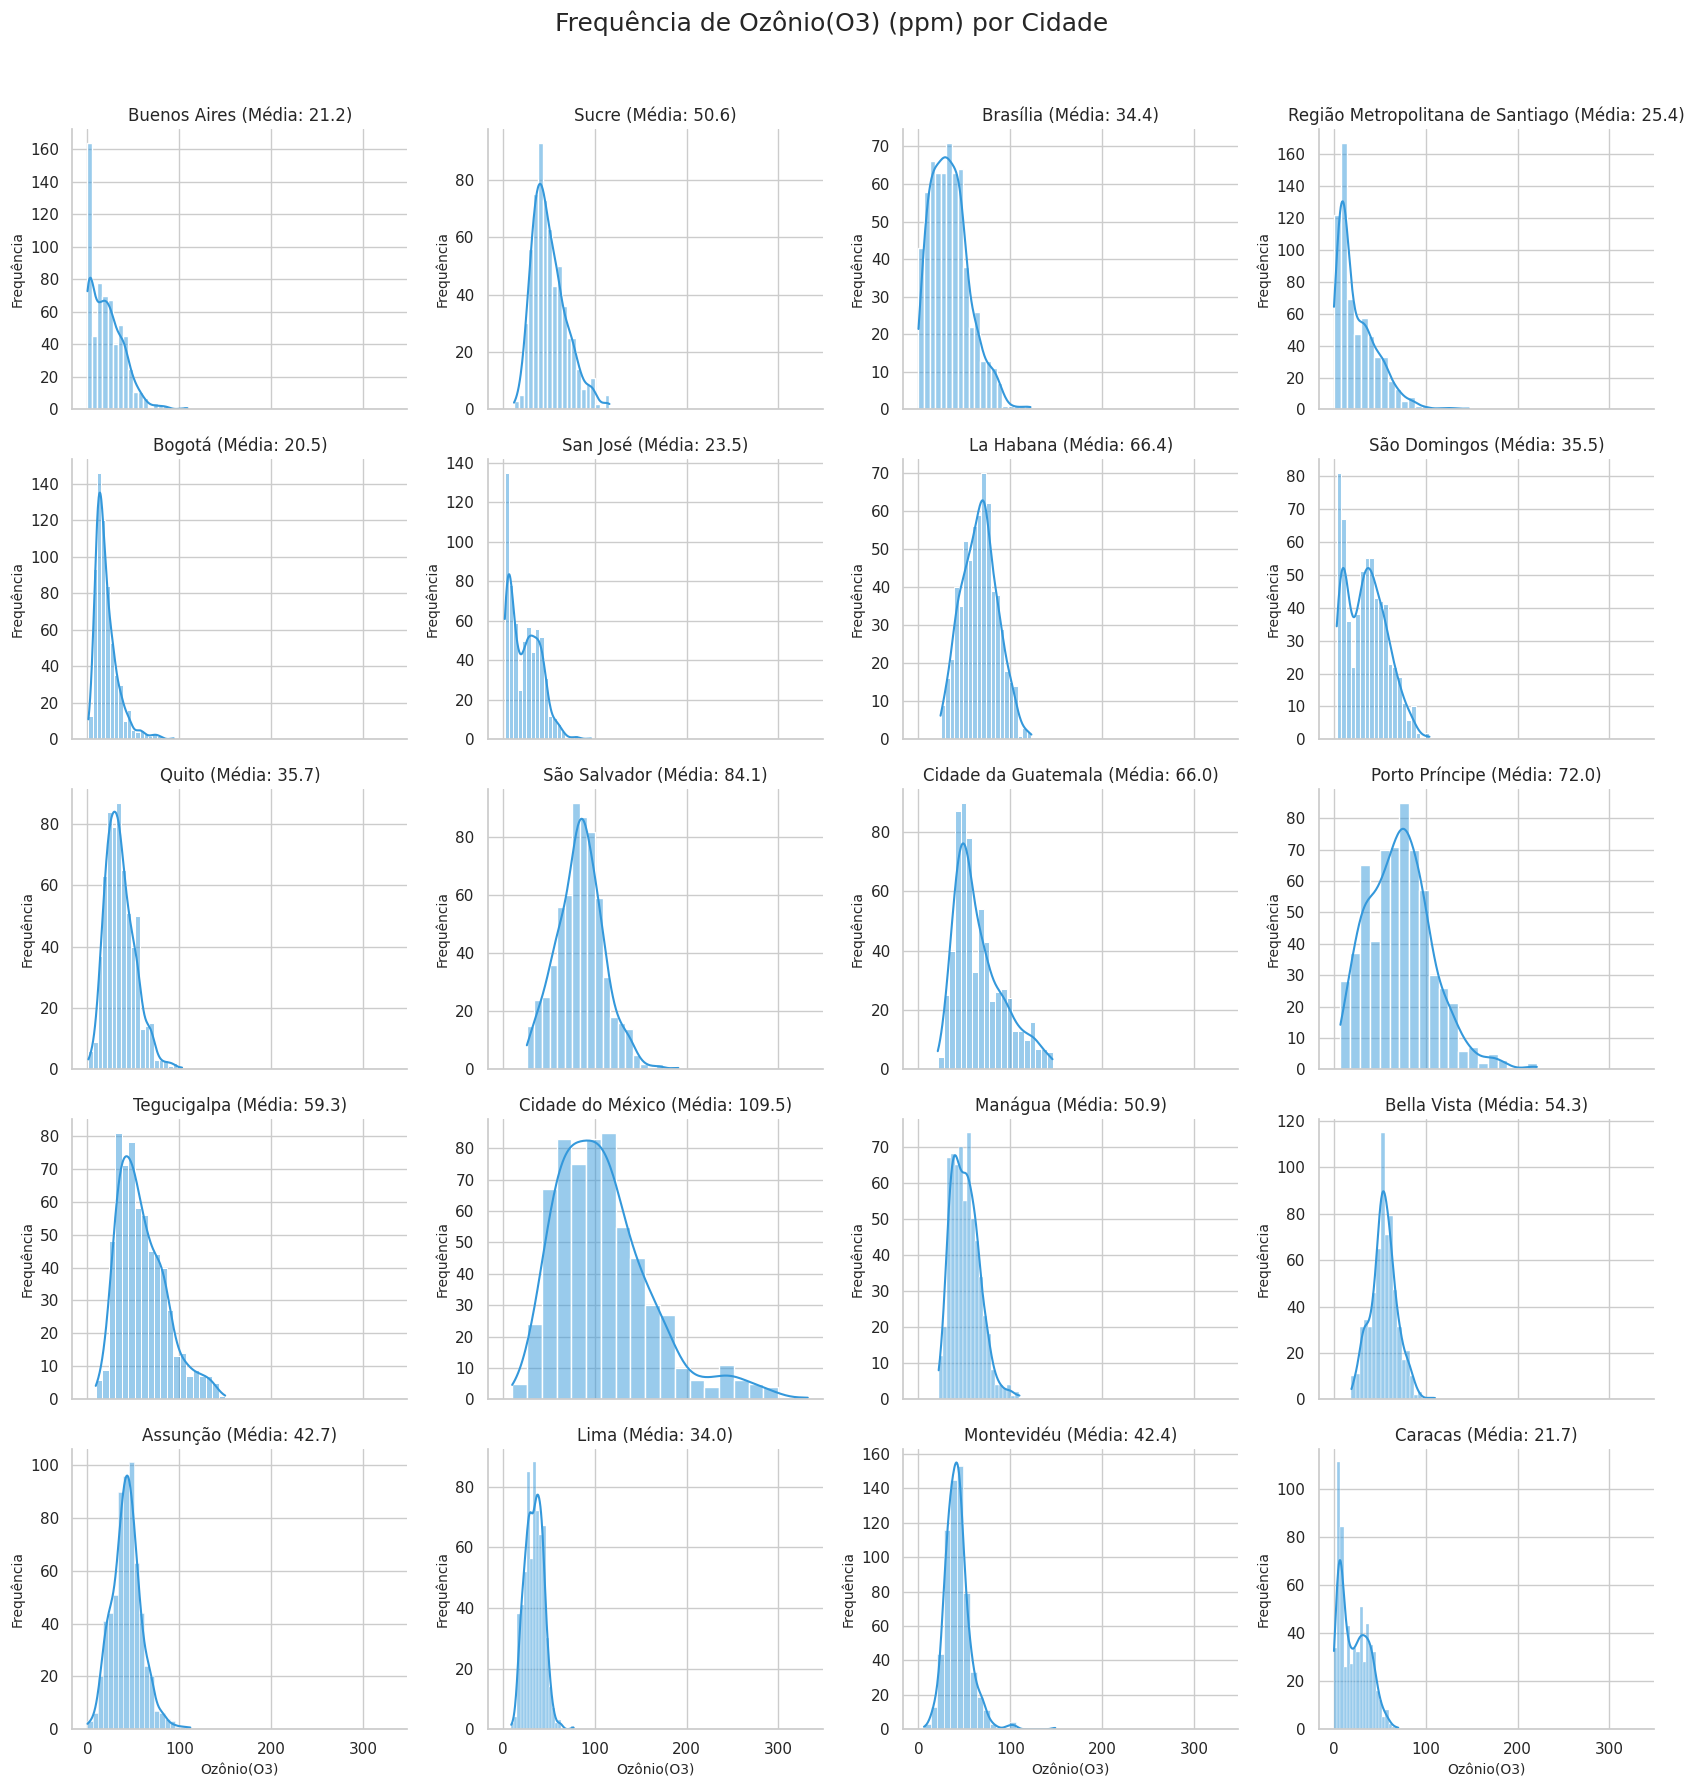

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. PREPARAÇÃO DE DADOS ---

# 1. Garantir que a coluna 'Data' seja do tipo datetime (necessário para a próxima fase de EDA, mas mantemos)
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')
df_plot = dados_clima.dropna(subset=['Cidade']).copy()

# 2. IDENTIFICAÇÃO DOS INDICADORES (Ajuste esta lista conforme seu DataFrame)
indicadores_candidatos = ['PM10', 'PM2_5', 'Monóxido de Carbono (CO2)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']
colunas_disponiveis = df_plot.columns.tolist()
indicadores_poluicao = [ind for ind in indicadores_candidatos if ind in colunas_disponiveis]

# Mapeamento de unidade e título (para o gráfico ficar mais limpo)
unidades = {
    'PM10': 'μg/m³',
    'PM2_5': 'μg/m³',
    'Ozônio(O3)': 'ppm',
    'Dióxido de Nitrogênio (NO2)': 'ppm',
    'Monóxido de Carbono (CO2)': 'ppm',
    'Dióxido de Enxofre(SO2)':'ppm'
}

print(f"✅ Indicadores prontos para histogramas: {indicadores_poluicao}")

# --- 3. FUNÇÃO PARA GERAR O HISTOGRAMA COM FACETAMENTO POR CIDADE ---

def plot_histogramas_facetados(df, indicador, unidade):

    # Remove NaN apenas para o indicador atual e a cidade
    df_indicador = df.dropna(subset=[indicador, 'Cidade'])

    if df_indicador.empty:
        print(f"Aviso: Não há dados válidos para o indicador {indicador}. Gráfico ignorado.")
        return

    # Define o número de cidades e o tamanho do grid
    n_cidades = df_indicador['Cidade'].nunique()
    # Ajuste o tamanho da figura para acomodar o número de cidades (ex: 2 linhas, N/2 colunas)
    cols = min(4, n_cidades) # Máximo de 4 colunas
    rows = int(np.ceil(n_cidades / cols))

    # O FacetGrid é ideal para criar painéis de subplots baseados em uma categoria (Cidade)
    g = sns.FacetGrid(
        df_indicador,
        col="Cidade",
        col_wrap=cols, # Número de colunas no grid
        sharey=False,  # Permite que o eixo Y seja diferente para cada cidade (melhor para distribuição)
        height=3.5,
        aspect=1.2 # Aspecto mais largo
    )

    # Mapeia a função de histograma para cada painel
    g.map(
        sns.histplot,
        indicador,
        kde=True, # Adiciona a curva de densidade (suaviza a distribuição)
        bins=20,  # Número de caixas/intervalos
        color="#3498db" # Cor de fundo
    )

    # Adiciona títulos e ajusta layout
    titulo_principal = f'Frequência de {indicador} ({unidade.get(indicador, "Unidade")}) por Cidade'
    g.fig.suptitle(titulo_principal, fontsize=18, y=1.02)

    # Ajusta os rótulos de cada subplot (opcional)
    for ax in g.axes.flat:
        ax.set_xlabel(indicador, fontsize=10)
        ax.set_ylabel("Frequência", fontsize=10)
        # Adiciona a média no título do subplot para referência
        media = df_indicador.loc[df_indicador['Cidade'] == ax.get_title().split('=')[1].strip(), indicador].mean()
        ax.set_title(f"{ax.get_title().split('=')[1].strip()} (Média: {media:.1f})")

    plt.tight_layout() # Garante que os títulos e rótulos não se sobreponham
    plt.show()


# --- 4. EXECUÇÃO DO LOOP ---

for indicador in indicadores_poluicao:
    plot_histogramas_facetados(df_plot, indicador, unidades)

2- Gráficos de violino no que diz respeito a cada indicador de ar considerando cada capital

In [7]:
# Obter coordenadas únicas
coordenadas_unicas = dados_clima[['Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)

# Usar a API Nominatim (OpenStreetMap)
geolocator = Nominatim(user_agent="qualidade_ar_analise")
nomes = []

print("🔎 Consultando cidades... (pode demorar um pouco)")
for i, row in coordenadas_unicas.iterrows():
    try:
        location = geolocator.reverse((row['Latitude'], row['Longitude']), language='pt')
        if location and 'address' in location.raw:
            cidade = (location.raw['address'].get('city') or
                      location.raw['address'].get('town') or
                      location.raw['address'].get('state') or
                      "Desconhecida")
        else:
            cidade = "Desconhecida"
        nomes.append(cidade)
        print(f"→ {row['Latitude']}, {row['Longitude']} → {cidade}")
    except Exception as e:
        print(f"⚠️ Erro em {i}: {e}")
        nomes.append("Erro")
    time.sleep(1)  # evita bloqueio de requisições pela API

coordenadas_unicas["Cidade"] = nomes

# Juntar as cidades ao DataFrame original
dados_clima = dados_clima.merge(coordenadas_unicas, on=["Latitude", "Longitude"], how="left")

# Converter o DataFrame para formato longo (ideal para gráficos)
dados_longos = dados_clima.melt(
    id_vars=["Cidade"],
    value_vars=['PM10', 'PM2_5', 'Monóxido de Carbono (CO2)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)'],
    var_name="Indicador",
    value_name="Valor"
)

🔎 Consultando cidades... (pode demorar um pouco)
→ -34.6037, -58.3816 → Buenos Aires
→ -19.0196, -65.2619 → Sucre
→ -15.8267, -47.9218 → Brasília
→ -33.4378, -70.6504 → Região Metropolitana de Santiago
→ 4.711, -74.0721 → Bogotá
→ 9.9281, -84.0907 → San José
→ 23.1136, -82.3666 → La Habana
→ 18.4861, -69.9312 → São Domingos
→ -0.1807, -78.4678 → Quito
→ 13.6929, -89.2182 → São Salvador
→ 14.6349, -90.5069 → Cidade da Guatemala
→ 18.5944, -72.3074 → Porto Príncipe
→ 14.0723, -87.1921 → Tegucigalpa
→ 19.4326, -99.1332 → Cidade do México
→ 12.114, -86.2362 → Manágua
→ 8.9824, -79.5199 → Bella Vista
→ -25.2637, -57.5759 → Assunção
→ -12.0464, -77.0428 → Lima
→ -34.9011, -56.1645 → Montevidéu
→ 10.4806, -66.9036 → Caracas


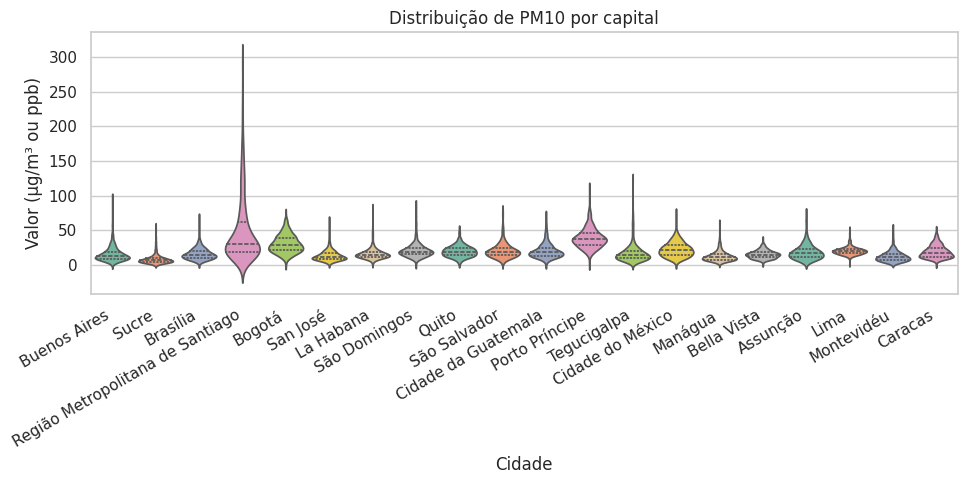

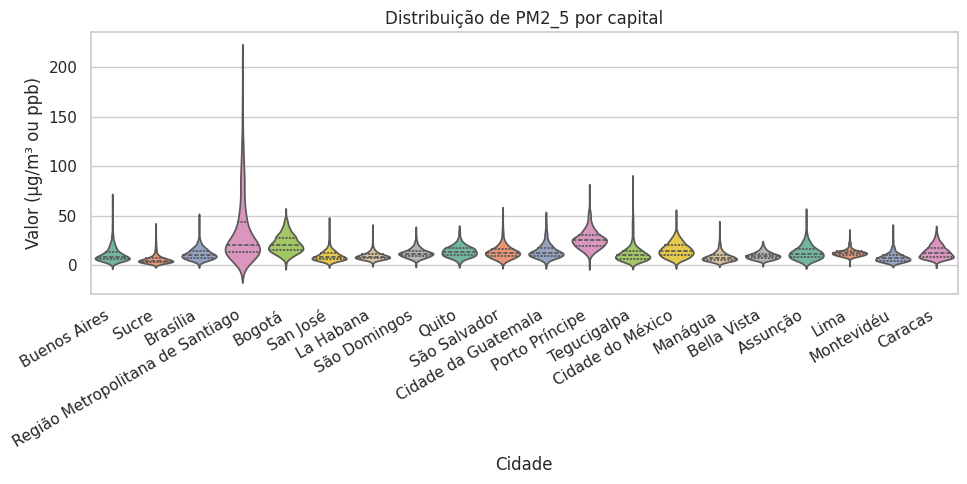

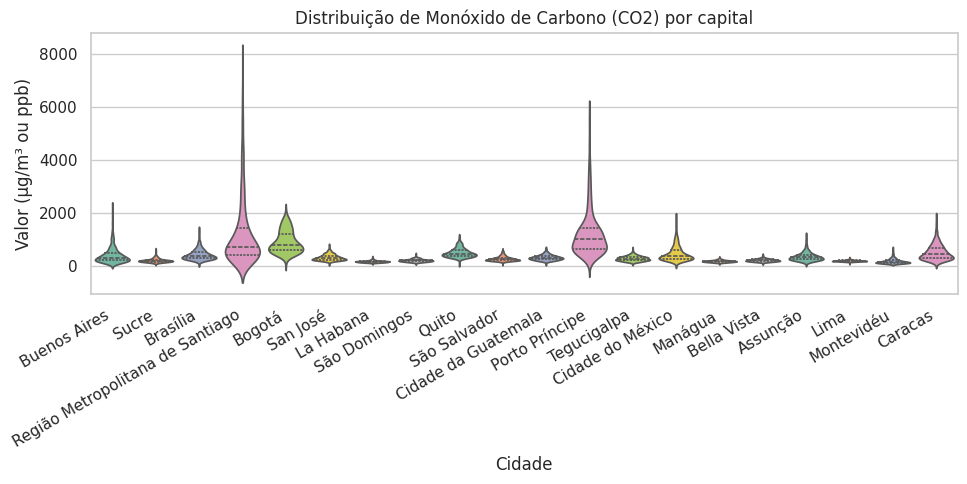

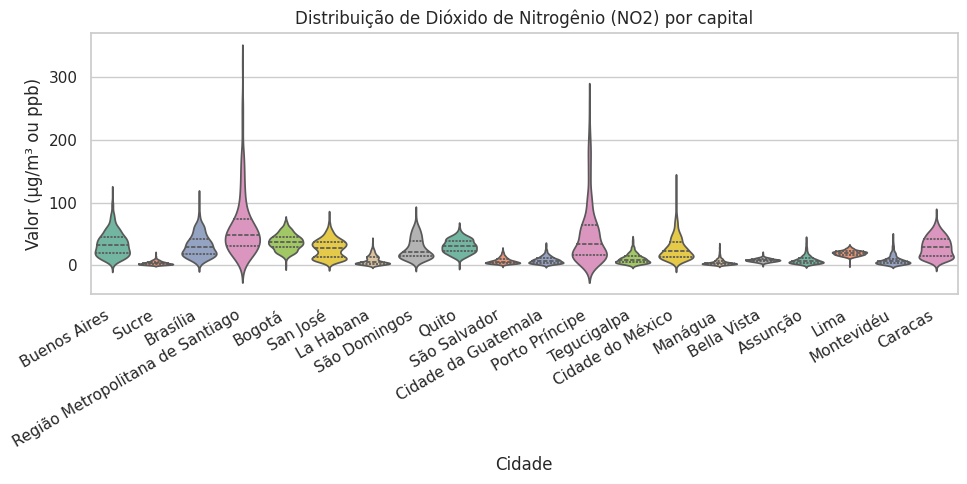

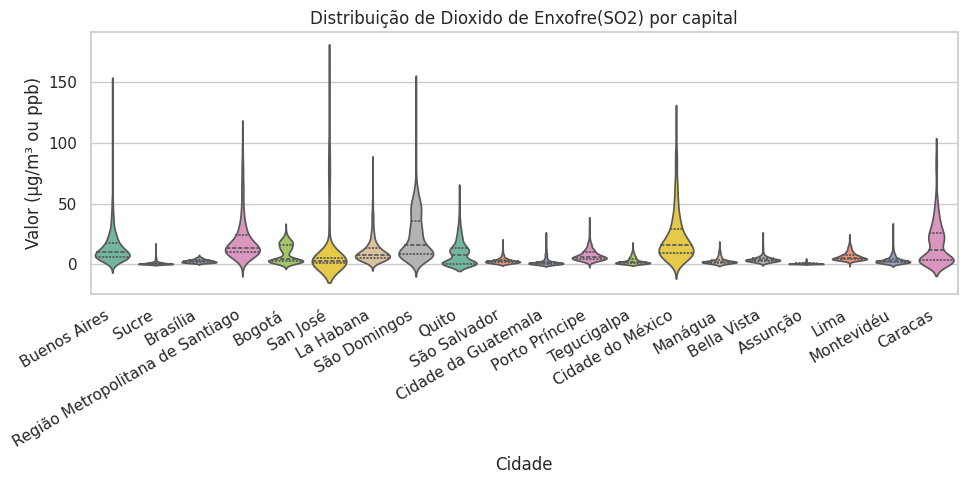

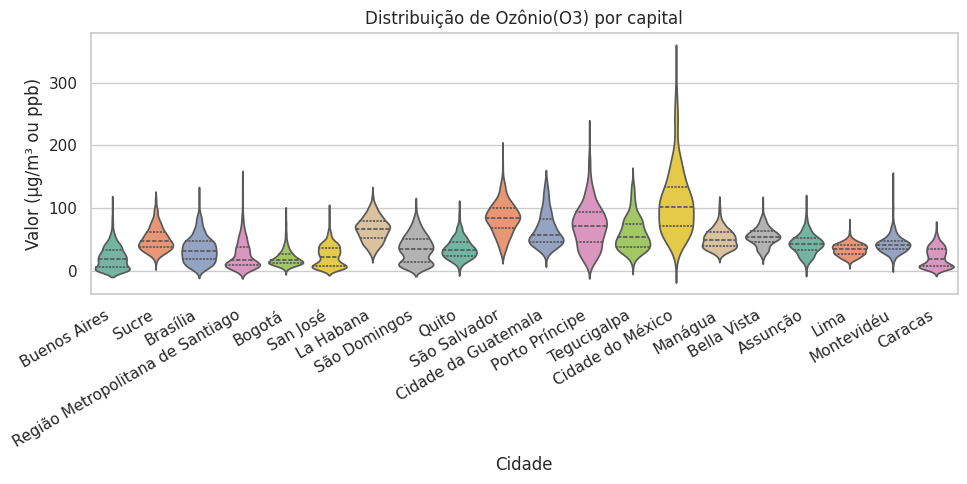

In [8]:
# Garantir que só existam linhas válidas
dados_longos = dados_longos.dropna(subset=["Valor", "Cidade"])

# Configurações de estilo
sns.set(style="whitegrid")

# Gerar um gráfico separado para cada indicador
indicadores = dados_longos["Indicador"].unique()

for indicador in indicadores:
    plt.figure(figsize=(10, 5))

    sns.violinplot(
        data=dados_longos[dados_longos["Indicador"] == indicador],
        x="Cidade", y="Valor",
        hue="Cidade",      # cores diferentes por cidade
        inner="quartile",
        palette="Set2",
        dodge=False        # mantém violinos sobrepostos ou separados
    )




    plt.title(f"Distribuição de {indicador} por capital")
    plt.xlabel("Cidade")
    plt.ylabel("Valor (μg/m³ ou ppb)")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

3- fazer um calendário de heatmap pros niveis de ar e olhar se tem alguma sazonalidade de brasilia ou geral de tudo

4- Describe geral da tabela, mostrando os dados que temos e algumas caracteristicas gerais deles

In [6]:
dados_clima.describe()

Latitude     Longitude          PM10         PM2_5  \
count  12640.000000  12640.000000  12520.000000  12520.000000   
mean      -0.351840    -74.647240     20.669625     13.758530   
std       19.473623     12.946283     16.881122     11.665622   
min      -34.901100    -99.133200      0.300000      0.200000   
25%      -16.624925    -84.627075     11.400000      7.500000   
50%        9.455250    -75.557450     17.100000     11.200000   
75%       14.212950    -66.493175     24.700000     16.500000   
max       23.113600    -47.921800    292.400000    204.900000   

       Monóxido de Carbono (CO2)  Dióxido de Nitrogênio (NO2)  \
count               12520.000000                 12520.000000   
mean                  414.904233                    22.484069   
std                   496.742344                    24.845234   
min                    58.000000                     0.000000   
25%                   181.000000                     6.700000   
50%                   263.000000                    15.100000   
75%                   444.000000                    30.900000   
max                  7635.000000                   324.400000   

       Dioxido de Enxofre(SO2)    Ozônio(O3)  
count             12520.000000  12520.000000  
mean                  8.930359     47.499201  
std                  13.674541     32.397686  
min                   0.000000      0.000000  
25%                   1.700000     26.000000  
50%                   4.100000     42.000000  
75%                  10.200000     62.000000  
max                 166.200000    332.000000

5- visualização geral dos indices, com mapa interativo da seria temporal mostrando a evolução da temp, da evapotranspiração e do vento

tentar juntar isso com uma visualização geral das variaveis

6- estruturar uma ideia pra medir a qualidade do ar

✅ Indicadores a serem analisados: ['PM10', 'PM2_5', 'Dióxido de Nitrogênio (NO2)', 'Ozônio(O3)', 'Monóxido de Carbono (CO2)', 'Dioxido de Enxofre(SO2)']


/tmp/ipython-input-3343235497.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



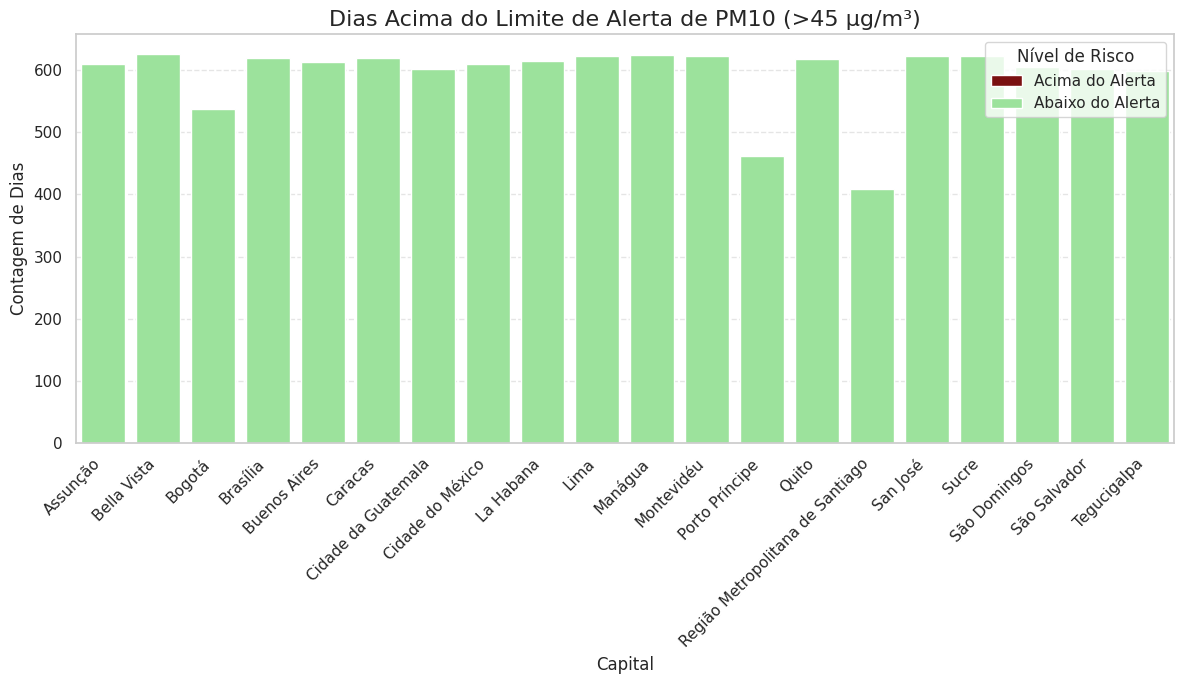

/tmp/ipython-input-3343235497.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



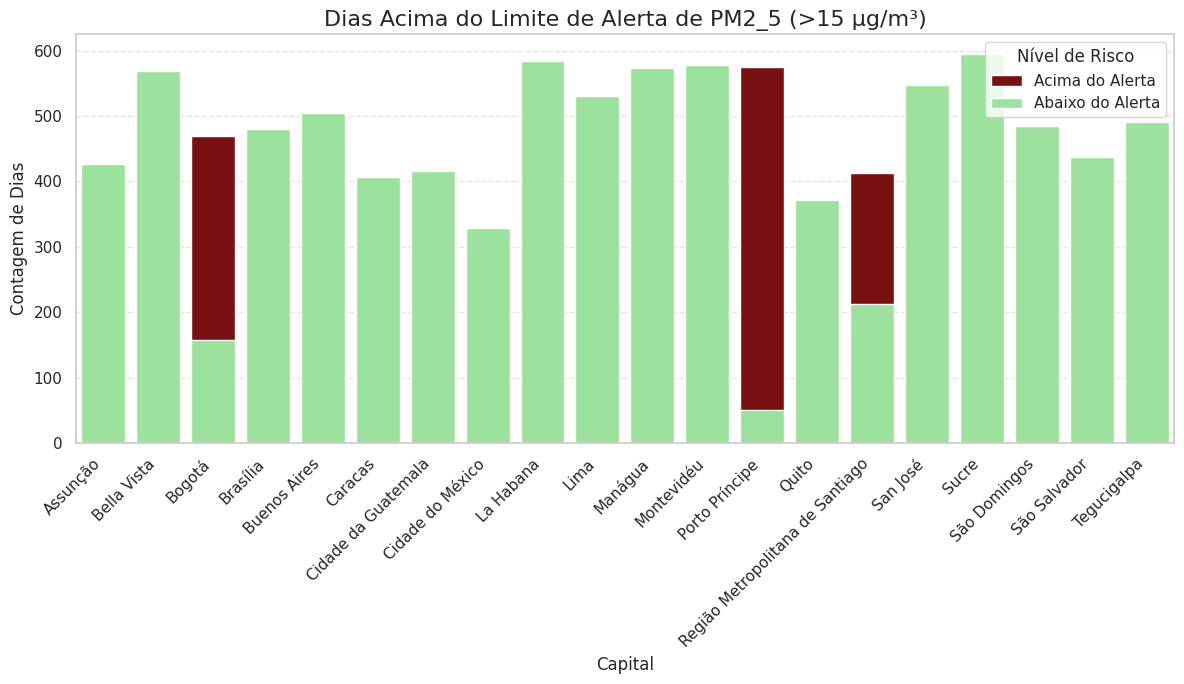

/tmp/ipython-input-3343235497.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



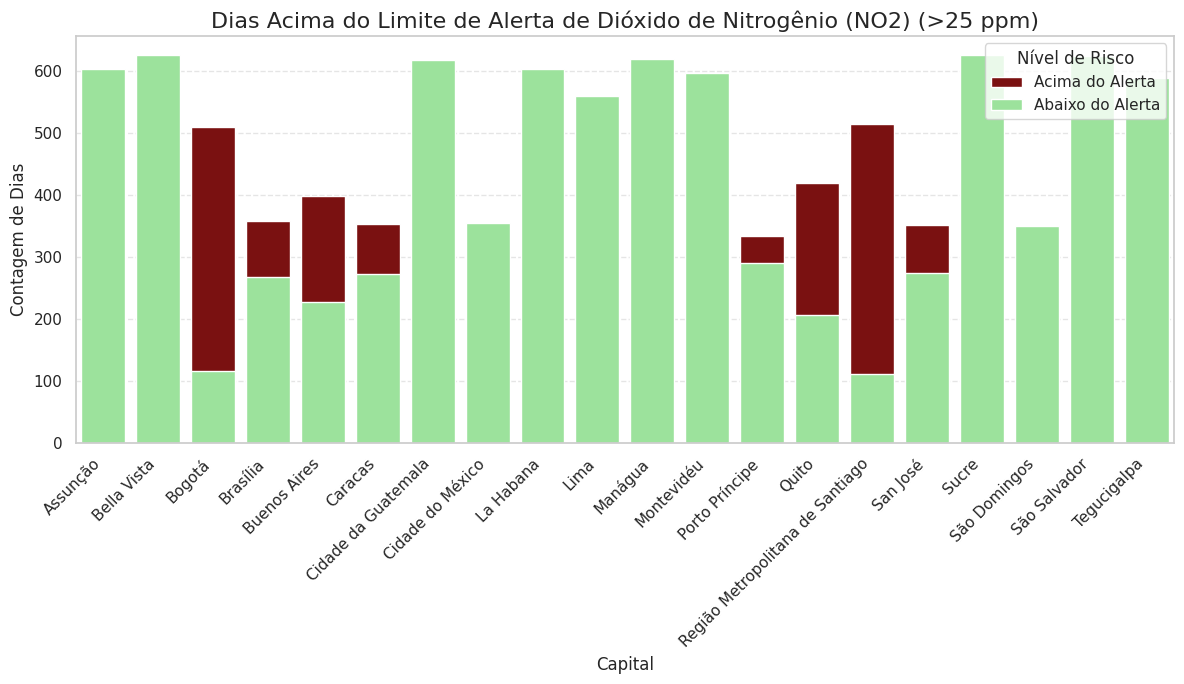

/tmp/ipython-input-3343235497.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



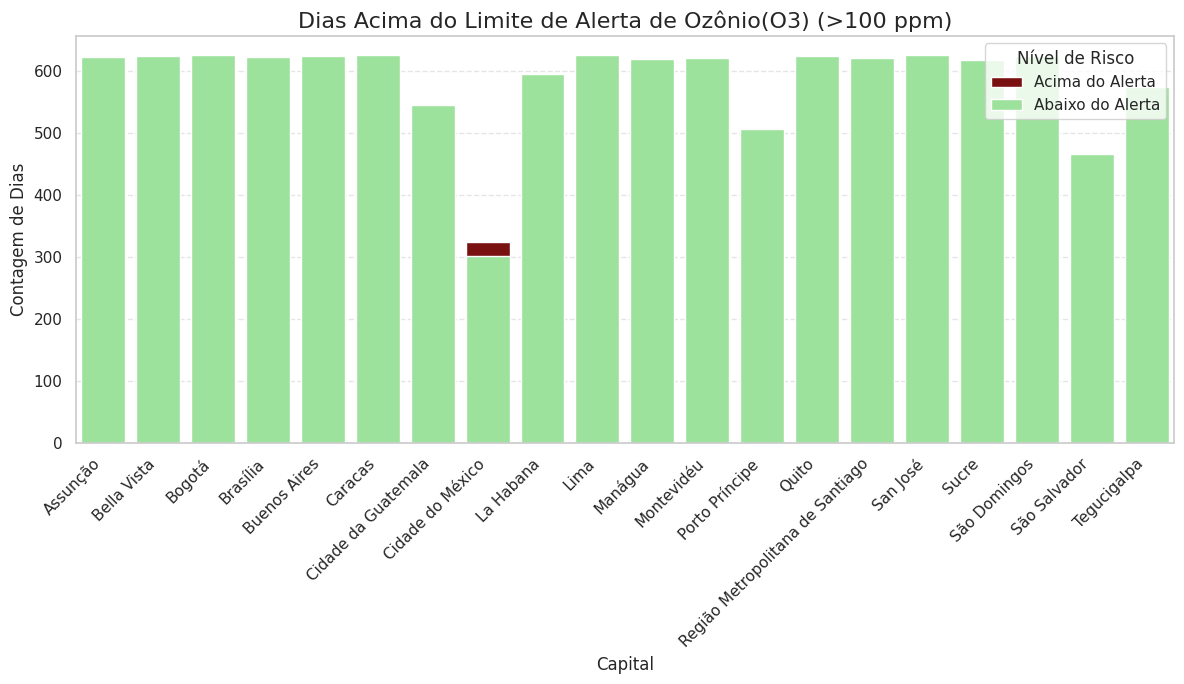

/tmp/ipython-input-3343235497.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



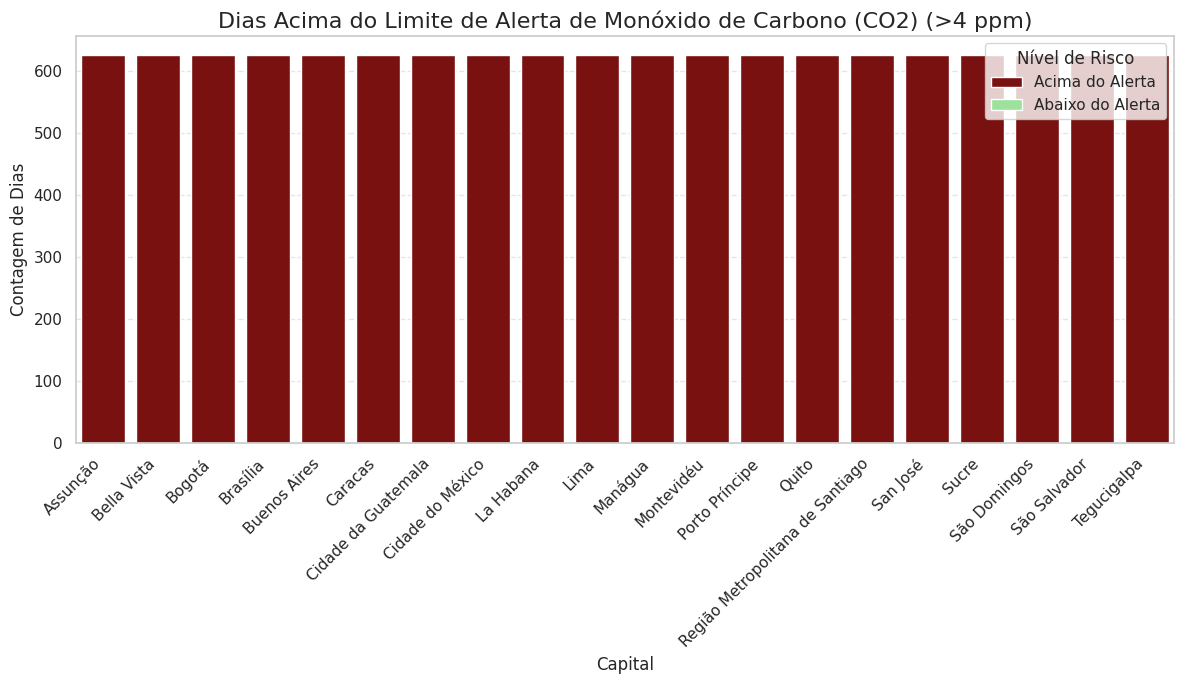

/tmp/ipython-input-3343235497.py:58: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



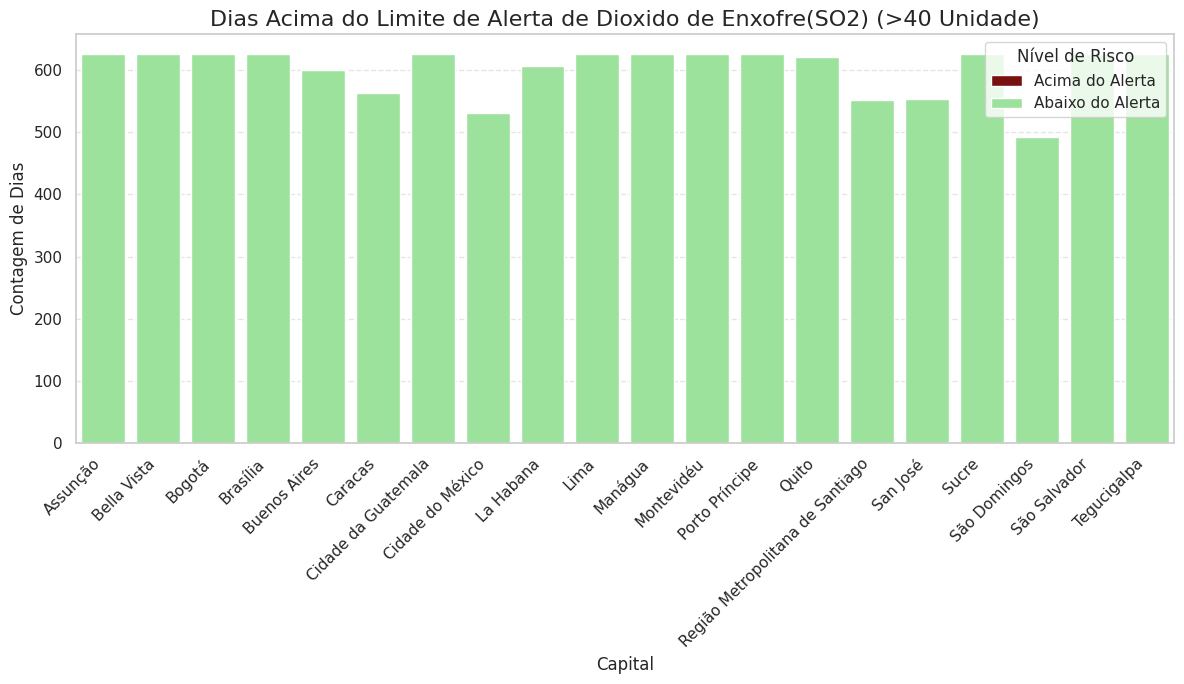

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0. PREPARAÇÃO E DEFINIÇÃO DE LIMITES ---

# 1. Garantir que a coluna 'Data' seja do tipo datetime (manter)
dados_clima['Data'] = pd.to_datetime(dados_clima['Data'], errors='coerce')
df_eventos_base = dados_clima.dropna(subset=['Cidade']).copy()

# 2. DEFINIÇÃO DE LIMITES DE ALERTA (Ajuste estes valores conforme a norma desejada)
# Assumimos limites diários ou de 24h, exceto para CO (que geralmente é 8h)
limites_alerta = {
    'PM10': 45,    # μg/m³
    'PM2_5': 15,   # μg/m³
    'Dióxido de Nitrogênio (NO2)': 25,    # μg/m³
    'Ozônio(O3)': 100,     # μg/m³
    'Monóxido de Carbono (CO2)': 4,       # ppm
    'Dioxido de Enxofre(SO2)': 40      # μg/m³
}

# Filtra a lista para incluir SOMENTE as colunas que realmente existem no DataFrame
colunas_disponiveis = df_eventos_base.columns.tolist()
indicadores_poluicao = [ind for ind in limites_alerta.keys() if ind in colunas_disponiveis]

# Dicionário de unidades (para o título)
unidades = {
    'PM10': 'μg/m³',
    'PM2_5': 'μg/m³',
    'Ozônio(O3)': 'ppm',
    'Dióxido de Nitrogênio (NO2)': 'ppm',
    'Monóxido de Carbono (CO2)': 'ppm',
    'Dióxido de Enxofre(SO2)':'ppm'
}

print(f"✅ Indicadores a serem analisados: {indicadores_poluicao}")

# --- 3. FUNÇÃO PARA GERAR O GRÁFICO DE BARRAS EMPILHADAS ---

def plot_contagem_de_eventos(df_base, indicador, limite, unidade):

    # Remove NaN para as colunas necessárias para o plot
    df_plot = df_base.dropna(subset=[indicador, 'Cidade']).copy()

    if df_plot.empty:
        print(f"Aviso: Dados insuficientes para plotar {indicador}.")
        return

    # CLASSIFICAÇÃO POR CATEGORIA DE RISCO
    df_plot['Risco'] = pd.cut(
        df_plot[indicador],
        bins=[-float('inf'), limite, float('inf')],
        labels=['Abaixo do Alerta', 'Acima do Alerta'],
        right=False
    )

    # AGRUPAMENTO E CONTAGEM
    df_contagem = df_plot.groupby(['Cidade', 'Risco']).size().reset_index(name='Contagem_Dias')

    # Garantir a ordem das categorias (importante para o empilhamento)
    df_contagem['Risco'] = pd.Categorical(
        df_contagem['Risco'],
        categories=['Abaixo do Alerta', 'Acima do Alerta'],
        ordered=True
    )

    # --- GERAÇÃO DO PLOT ---
    plt.figure(figsize=(12, 7))

    sns.barplot(
        data=df_contagem,
        x='Cidade',
        y='Contagem_Dias',
        hue='Risco',
        hue_order=['Acima do Alerta', 'Abaixo do Alerta'], # O mais crítico primeiro
        dodge=False, # Essencial para empilhar
        palette={'Acima do Alerta': 'darkred', 'Abaixo do Alerta': 'lightgreen'}
    )

    # AJUSTES FINAIS DO LAYOUT
    unidade_str = unidade.get(indicador, 'Unidade')
    titulo = f'Dias Acima do Limite de Alerta de {indicador} (>{limite} {unidade_str})'

    plt.title(titulo, fontsize=16)
    plt.xlabel('Capital', fontsize=12)
    plt.ylabel('Contagem de Dias', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Nível de Risco', loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# --- 4. EXECUÇÃO DO LOOP PARA TODOS OS INDICADORES ---

for indicador in indicadores_poluicao:
    limite = limites_alerta[indicador]
    plot_contagem_de_eventos(df_eventos_base, indicador, limite, unidades)

##**Intervalo de Confiança**

1- A média dos níveis de poluição em Brasília difere de forma estatisticamente significativa da média das outras capitais da América Latina?

2- avaliar correlações entre os gases e as variavies do tempo


✅ Matriz de Correlação calculada com sucesso.


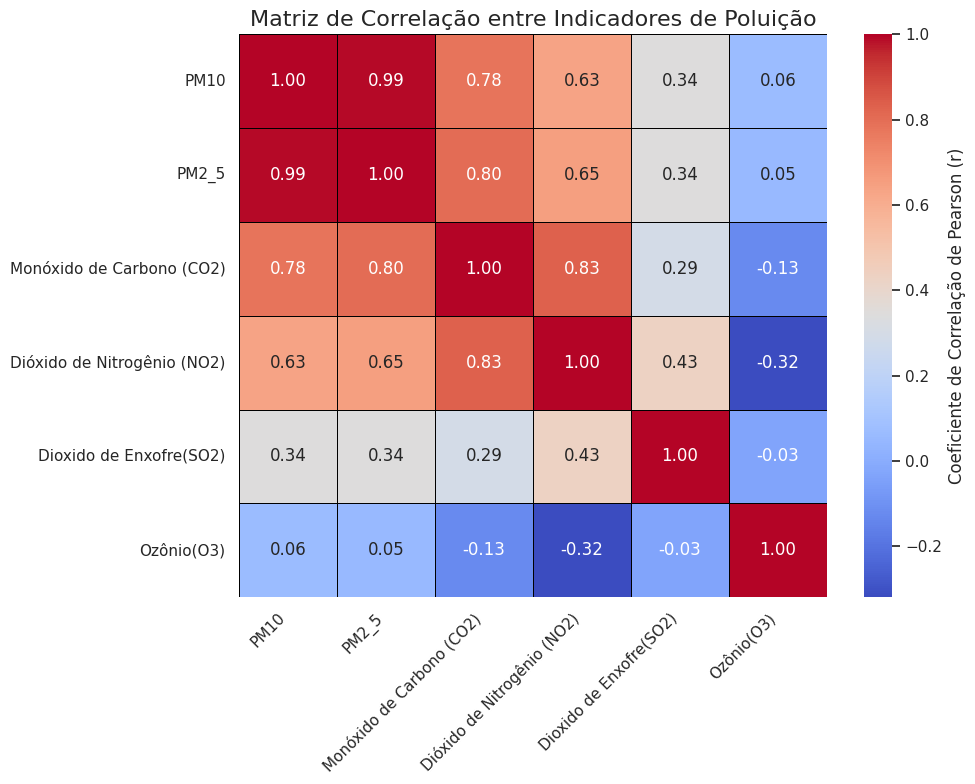


📈 Pares de Variáveis com Correlação Forte (|r| > 0.7):
  PM2_5 vs PM10: 0.99
  Dióxido de Nitrogênio (NO2) vs Monóxido de Carbono (CO2): 0.83
  Monóxido de Carbono (CO2) vs PM2_5: 0.80
  Monóxido de Carbono (CO2) vs PM10: 0.78


In [21]:
# --- 0. PREPARAÇÃO DE DADOS ---

# 1. Definir os Indicadores de Interesse (mesma lista usada no Pair Plot)
# Ajuste esta lista para os nomes exatos das colunas no seu DataFrame.
INDICADORES_PARA_CORRELACAO = ['PM10', 'PM2_5', 'Monóxido de Carbono (CO2)', 'Dióxido de Nitrogênio (NO2)', 'Dioxido de Enxofre(SO2)', 'Ozônio(O3)']

# 2. Filtrar o DataFrame para incluir apenas as colunas de interesse
df_corr = dados_clima.copy()

# Remove colunas que não existem nos dados
colunas_presentes = [col for col in INDICADORES_PARA_CORRELACAO if col in df_corr.columns]
df_corr = df_corr[colunas_presentes]

# 3. Calcular a Matriz de Correlação
# O método .corr() do Pandas calcula o coeficiente de Pearson entre todos os pares
matriz_correlacao = df_corr.corr(numeric_only=True)

print("✅ Matriz de Correlação calculada com sucesso.")
# print(matriz_correlacao) # Descomente para ver a tabela de números

# --- 4. GERAÇÃO DO HEATMAP (Mapa de Calor) ---

plt.figure(figsize=(10, 8))

sns.heatmap(
    matriz_correlacao,
    annot=True,              # Mostra o valor numérico (coeficiente r) em cada célula
    cmap='coolwarm',         # Paleta de cores que destaca correlações positivas (quente/vermelho) e negativas (frio/azul)
    fmt=".2f",               # Formato de duas casas decimais para os números
    linewidths=.5,           # Linhas para separar as células
    linecolor='black',       # Cor das linhas
    cbar_kws={'label': 'Coeficiente de Correlação de Pearson (r)'} # Rótulo da barra de cor
)

plt.title('Matriz de Correlação entre Indicadores de Poluição', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# --- 5. Análise Opcional: Filtro de Alta Correlação ---
# Para simplificar a análise, você pode extrair pares com alta correlação (|r| > 0.7)

matriz_upper = matriz_correlacao.where(np.triu(np.ones(matriz_correlacao.shape), k=1).astype(bool))
pares_altamente_correlacionados = matriz_upper.unstack().sort_values(ascending=False).dropna()

print("\n📈 Pares de Variáveis com Correlação Forte (|r| > 0.7):")
for index, valor in pares_altamente_correlacionados.items():
    if abs(valor) >= 0.7:
        print(f"  {index[0]} vs {index[1]}: {valor:.2f}")

##**Regressão:**

1- É possível desenvolver um modelo de regressão que preveja os níveis de PM2.5 para cidades da América Latina, usando dados meteorológicos e históricos como entrada?

2- Quais variáveis meteorológicas (temperatura, velocidade do vento, pressão atmosférica) são os preditores mais importantes para a qualidade do ar, e essa importância varia entre as diferentes regiões ?